# Plot 

In [13]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
def compute_mmd(x_,y_, bandwidth):
    """
    Compute the mean and standard deviation of the MMD between x and y.
    :param x_: (N_x,d)
    :param y_: (N_y,d)
    :return:
    """
    x = tf.convert_to_tensor(x_, dtype=tf.float32)
    y = tf.convert_to_tensor(y_, dtype=tf.float32)

    xx = tf.matmul(x,tf.transpose(x))
    xy = tf.matmul(x,tf.transpose(y))
    yy = tf.matmul(y,tf.transpose(y))

    rx = tf.reduce_sum(tf.square(x), axis=-1, keepdims=True)
    ry = tf.reduce_sum(tf.square(y), axis=-1, keepdims=True)

    se_xx = rx - 2*xx + tf.transpose(rx)
    se_xy = rx - 2*xy + tf.transpose(ry)
    se_yy = ry - 2*yy + tf.transpose(ry)

    K_xx = tf.exp(-0.5 * se_xx / (bandwidth**2) )
    K_xy = tf.exp( -0.5 * se_xy / (bandwidth**2) )
    K_yy = tf.exp( -0.5 * se_yy / (bandwidth**2) )

    return tf.reduce_mean(K_xx) - 2*tf.reduce_mean(K_xy) + tf.reduce_mean(K_yy)

In [15]:
figure_path = os.path.join(os.getcwd(), 'figures')
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

## Toy Example MCMC

In [16]:
model_name = "nn"
selected_round = 1
n = 50
ps_path = os.path.join(os.getcwd(), "Toy_Example", "data", f"ps.npy")
mcmc_samples_path = os.path.join(os.getcwd(), "Toy_Example", "result", f"{model_name}_mcmc_samples", f"{model_name}_{n}_mcmc_samples_{selected_round}.npy")
bandwidhth_path = os.path.join(os.getcwd(), "Toy_Example", "data", "h_mmd.npy")

In [17]:
ps_samples = np.load(ps_path)
print(f"Loaded parameter samples from {ps_path}")
print(f"Shape of parameter samples: {ps_samples.shape}")

mcmc_samples = np.load(mcmc_samples_path)
print(f"Loaded MCMC samples from {mcmc_samples_path}")
print(f"Shape of MCMC samples: {mcmc_samples.shape}")

bandwidth = np.load(bandwidhth_path)
print(f"Loaded bandwidth from {bandwidhth_path}")

Loaded parameter samples from /Users/mike-fx/Desktop/library/code_warehouse/AutoSummary_GenerativeNetwork/Toy_Example/data/ps.npy
Shape of parameter samples: (10000, 5)
Loaded MCMC samples from /Users/mike-fx/Desktop/library/code_warehouse/AutoSummary_GenerativeNetwork/Toy_Example/result/nn_mcmc_samples/nn_50_mcmc_samples_1.npy
Shape of MCMC samples: (350, 1000, 5)
Loaded bandwidth from /Users/mike-fx/Desktop/library/code_warehouse/AutoSummary_GenerativeNetwork/Toy_Example/data/h_mmd.npy


In [18]:
selected_element_index = 0
upper_labels=["\\theta_1","\\theta_2","\\theta_3","\\theta_4","\\theta_5"]

burn_in = 0
thin = 20
plot_thin = 40
n_samples = 201

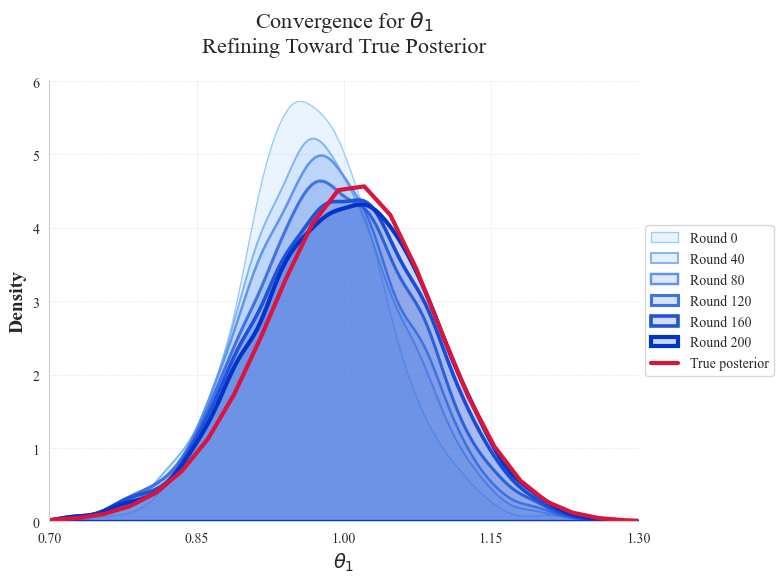

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set a more modern style
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

# Create a custom colormap for iteration progression (light to dark blue)
colors = [(0.6, 0.8, 1), (0, 0.2, 0.8)]  # Light to dark blue
cmap = LinearSegmentedColormap.from_list("iteration_cmap", colors, N=20)

# Assuming these variables are defined in your original code
# burn_in, n_samples, thin, mcmc_samples, ps_samples, selected_element_index = ...

fig, axs = plt.subplots(1, 1, figsize=(8, 6))  # Slightly wider for better readability

true_ps = [1, 1, -1.0, -0.9, 0.6]
x_limits = [
    [0.7, 1.3],  # theta_0
    [0.6, 1.4],  # theta_1
    [-1.5, 1.5], # theta_2
    [-1.5, 1.5], # theta_3
    [0, 1.2],    # theta_4
]

# Set axis limits and ticks
axs.set_xlim(x_limits[selected_element_index])
axs.set_xticks(np.linspace(x_limits[selected_element_index][0], 
                           x_limits[selected_element_index][1], 5))

# Add vertical line for true parameter value - crucial reference point
# true_value = true_ps[selected_element_index]
# axs.axvline(x=true_value, color='black', linestyle='--', linewidth=2, 
#             label=f'True value: {true_value:.1f}')

thinning_index = []
iterations_plotted = []  # To track which iterations we plot

for i in range(burn_in + n_samples):
    # Maintain thinning index logic
    if i % thin == 0:
        if len(thinning_index) < 6:
            thinning_index.append(i)
        else:
            thinning_index.pop(0)
            thinning_index.append(i)

        if i % plot_thin == 0:  # Plot every 'plot_thin' iterations
            # Calculate progression factor (0 to 1) for visual encoding
            progress = (i ) / (n_samples)
            iterations_plotted.append((i, progress))
            
            # Combine samples
            mcmc_posterior_samples = np.concatenate([mcmc_samples[idx] for idx in thinning_index], axis=0)
            
            # Plot with visual progression
            sns.kdeplot(
                mcmc_posterior_samples[:, selected_element_index],
                ax=axs,
                fill=True,  # Subtle fill for better distinction
                alpha=0.2,  # Transparent fill
                label=f"Round {i}" if len(iterations_plotted) <= 6 else "",  # Avoid legend clutter
                linewidth=1 + 2*progress,  # Later iterations have thicker lines
                color=cmap(progress),  # Color progresses with iterations
            )

# Plot true posterior with high contrast
sns.kdeplot(
    ps_samples[:, selected_element_index],
    ax=axs,
    fill=False,
    label="True posterior",
    color="crimson",  # More vibrant red
    linestyle="-",
    linewidth=3,  # Thicker to stand out
)

# Improve legend - place outside plot if many items
handles, labels = axs.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
axs.legend(by_label.values(), by_label.keys(), 
           loc='center left', bbox_to_anchor=(1, 0.5),  # Place outside right
           frameon=True, framealpha=0.9, edgecolor='lightgray')

# Enhance labels and title
axs.set_xlabel(f"${upper_labels[selected_element_index]}$", fontweight='bold')
axs.set_ylabel("Density", fontweight='bold')
axs.set_title(f"Convergence for ${upper_labels[selected_element_index]}$\n"
              f"Refining Toward True Posterior", pad=20)

# Refine grid
axs.grid(color='lightgray', linestyle=':', linewidth=0.5)

# Remove top and right spines for cleaner look
sns.despine(ax=axs, top=True, right=True)

plt.tight_layout()
plt.show()

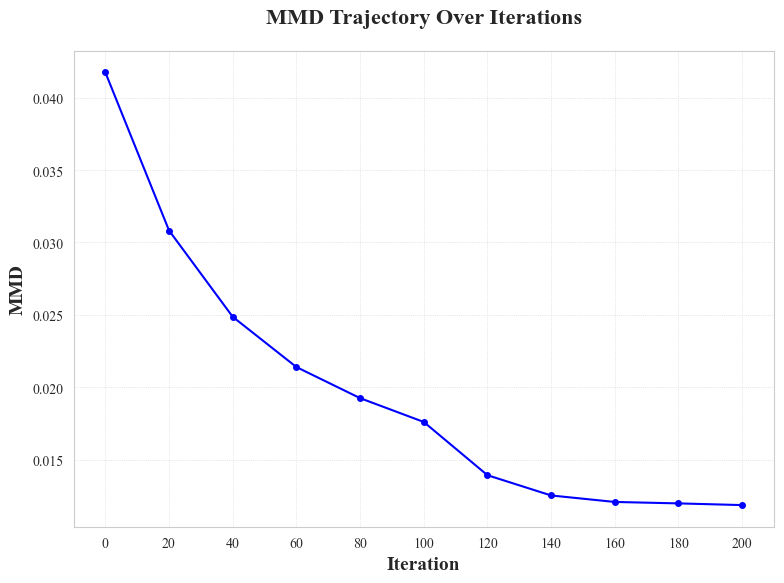

In [20]:
mmd_trajectory = []
thinning_index = []
iteration_ticks = []
for i in range(burn_in + n_samples):
    if i % thin == 0:
        if len(thinning_index) < 6:
            thinning_index.append(i)
        else:
            thinning_index.pop(0)
            thinning_index.append(i)

        mcmc_posterior_samples = np.concatenate([mcmc_samples[idx] for idx in thinning_index], axis=0)
        mmd_value = compute_mmd(mcmc_posterior_samples, ps_samples, bandwidth)
        mmd_trajectory.append(mmd_value.numpy())
        iteration_ticks.append(i)
# Plot MMD trajectory
plt.figure(figsize=(8, 6))
plt.plot(iteration_ticks, mmd_trajectory, marker='o', markersize=4, color='blue', linewidth=1.5)
plt.xlabel("Iteration", fontweight='bold')
plt.ylabel("MMD", fontweight='bold')
plt.title("MMD Trajectory Over Iterations", fontweight='bold', pad=20)
plt.grid(color='lightgray', linestyle=':', linewidth=0.5)
# 设置x轴刻度为每thin步
xticks = list(range(0, burn_in + n_samples, thin))
plt.xticks(xticks, [str(x) for x in xticks])
plt.tight_layout()
plt.show()

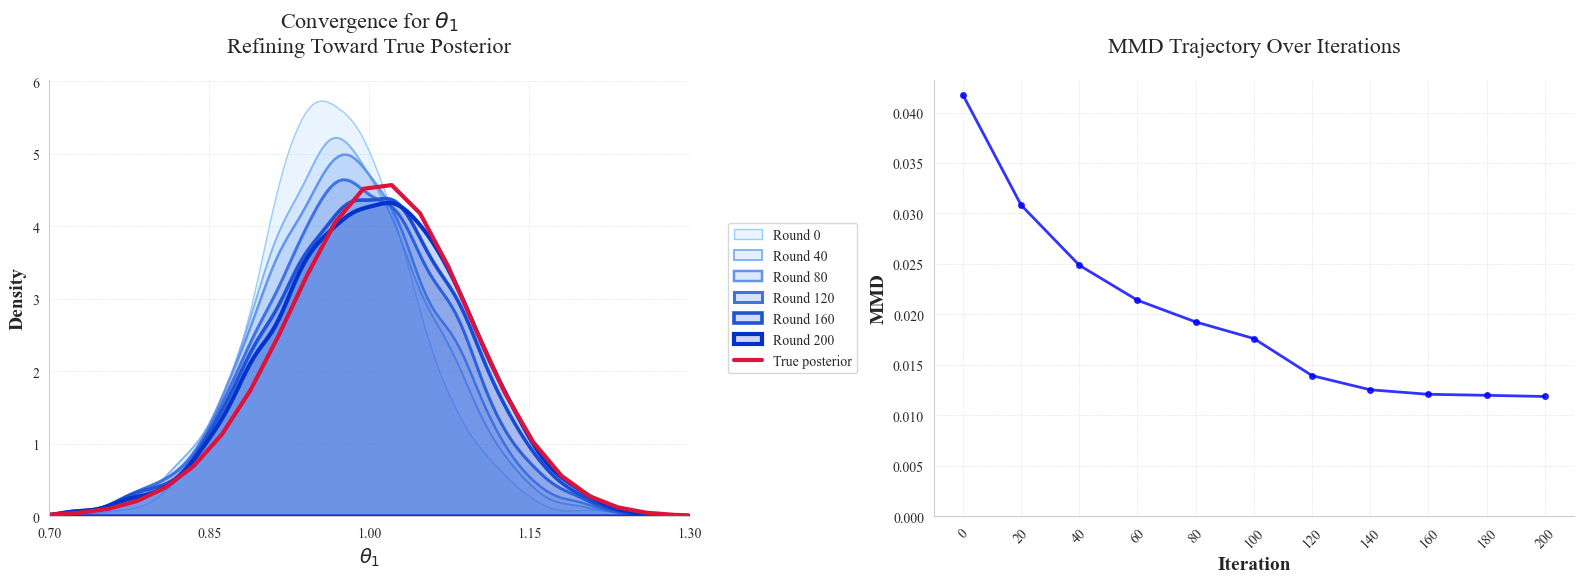

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# --------------------------
# 统一全局样式设置（与左图保持一致）
# --------------------------
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

# 自定义颜色映射（左图使用）
colors = [(0.6, 0.8, 1), (0, 0.2, 0.8)]  # 浅蓝色到深蓝色渐变
cmap = LinearSegmentedColormap.from_list("iteration_cmap", colors, N=20)

# --------------------------
# 创建左右拼图布局
# --------------------------
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1行2列，总宽度增加以容纳两张图
plt.subplots_adjust(wspace=0.3)  # 调整子图间距


# --------------------------
# 左图：MCMC收敛分布图
# --------------------------
# 左图数据参数
true_ps = [1, 1, -1.0, -0.9, 0.6]
x_limits = [
    [0.7, 1.3],  # theta_0
    [0.6, 1.4],  # theta_1
    [-1.5, 1.5], # theta_2
    [-1.5, 1.5], # theta_3
    [0, 1.2],    # theta_4
]

# 设置左图轴范围和刻度
ax_left = axs[0]
ax_left.set_xlim(x_limits[selected_element_index])
ax_left.set_xticks(np.linspace(
    x_limits[selected_element_index][0],
    x_limits[selected_element_index][1], 5
))

# 绘制MCMC迭代分布
thinning_index = []
iterations_plotted = []
for i in range(burn_in + n_samples):
    if i % thin == 0:
        if len(thinning_index) < 6:
            thinning_index.append(i)
        else:
            thinning_index.pop(0)
            thinning_index.append(i)
        
        if i % plot_thin == 0:  # 控制绘图频率
            progress = i / (n_samples)  # 进度因子（0-1）
            iterations_plotted.append((i, progress))
            
            # 合并样本
            mcmc_posterior_samples = np.concatenate(
                [mcmc_samples[idx] for idx in thinning_index], axis=0
            )
            
            # 绘制KDE曲线（带视觉进度效果）
            sns.kdeplot(
                mcmc_posterior_samples[:, selected_element_index],
                ax=ax_left,
                fill=True,
                alpha=0.2,
                label=f"Round {i}" if len(iterations_plotted) <= 6 else "",
                linewidth=1 + 2*progress,
                color=cmap(progress),
            )

# 绘制真实后验分布
sns.kdeplot(
    ps_samples[:, selected_element_index],
    ax=ax_left,
    fill=False,
    label="True posterior",
    color="crimson",
    linestyle="-",
    linewidth=3,
)

# 左图图例（放在右侧外部避免遮挡）
handles, labels = ax_left.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax_left.legend(
    by_label.values(), by_label.keys(),
    loc='center left', bbox_to_anchor=(1.05, 0.5),
    frameon=True, framealpha=0.9, edgecolor='lightgray'
)

# 左图标签和标题
ax_left.set_xlabel(f"${upper_labels[selected_element_index]}$", fontweight='bold')
ax_left.set_ylabel("Density", fontweight='bold')
ax_left.set_title(
    f"Convergence for ${upper_labels[selected_element_index]}$\nRefining Toward True Posterior",
    pad=20
)

# 左图网格和边框优化
ax_left.grid(color='lightgray', linestyle=':', linewidth=0.5)
sns.despine(ax=ax_left, top=True, right=True)


# --------------------------
# 右图：MMD轨迹图（风格与左图统一）
# --------------------------
ax_right = axs[1]

# 计算MMD轨迹数据
mmd_trajectory = []
thinning_index = []
iteration_ticks = []
for i in range(burn_in + n_samples):
    if i % thin == 0:
        if len(thinning_index) < 6:
            thinning_index.append(i)
        else:
            thinning_index.pop(0)
            thinning_index.append(i)
        
        mcmc_posterior_samples = np.concatenate(
            [mcmc_samples[idx] for idx in thinning_index], axis=0
        )
        mmd_value = compute_mmd(mcmc_posterior_samples, ps_samples, bandwidth)
        mmd_trajectory.append(mmd_value.numpy())
        iteration_ticks.append(i)

# 绘制MMD轨迹
ax_right.plot(
    iteration_ticks, mmd_trajectory,
    marker='o', markersize=4, color='blue', linewidth=2.0,
    alpha=0.8  # 轻微透明增加质感
)

# 右图标签和标题（与左图字体风格统一）
ax_right.set_xlabel("Iteration", fontweight='bold')
ax_right.set_ylabel("MMD", fontweight='bold')
ax_right.set_title("MMD Trajectory Over Iterations", pad=20)

# 右图网格和刻度设置（与左图一致）
ax_right.grid(color='lightgray', linestyle=':', linewidth=0.5)
xticks = list(range(0, burn_in + n_samples, thin))
ax_right.set_xticks(xticks)
ax_right.set_xticklabels([str(x) for x in xticks], rotation=45)  # 旋转刻度避免重叠

# 右图边框优化（与左图一致）
sns.despine(ax=ax_right, top=True, right=True)

# 确保y轴范围合理（根据数据自动调整）
ax_right.set_ylim(bottom=0)  # MMD非负，从0开始更合理


# --------------------------
# 整体布局调整并显示
# --------------------------
plt.tight_layout()
plt.savefig(os.path.join(figure_path, "mcmc_convergence_and_mmd_trajectory.png"), dpi=300, bbox_inches='tight')
plt.show()

## Toy Example

In [56]:
d = 5
n = 50
# color setting
truth_color = "#FF6B6B"
est_color = "#4D96FF"
refined_color = "#6BCB77"
upper_labels=["\\theta_1","\\theta_2","\\theta_3","\\theta_4","\\theta_5"]

In [57]:
model_name = ["nn", "bf", "dnnabc","w2abc"]
result_path = os.path.join(os.getcwd(), "Toy_Example", "result")

In [58]:
selected_ps_indexs = [6 ,0 , 0, 0, 8]
ps_samples = np.load(os.path.join(os.getcwd(), "Toy_Example", "data", "ps.npy"))
nn_ps = np.load(os.path.join(os.getcwd(), "Toy_Example", "result", "nn_ps", f"nn_{n}_ps_{selected_ps_indexs[0]}.npy"))
refined_nn_ps = np.load(os.path.join(os.getcwd(), "Toy_Example", "result", "nn_ps", f"nn_{n}_mcmc_{selected_ps_indexs[0]}.npy"))
bf_ps = np.load(os.path.join(os.getcwd(), "Toy_Example", "result", "bf_ps", f"bf_{n}_ps_{selected_ps_indexs[1]}.npy"))
refined_bf_ps = np.load(os.path.join(os.getcwd(), "Toy_Example", "result", "bf_ps", f"bf_{n}_ps_mcmc_{selected_ps_indexs[1]}.npy"))
dnnabc_ps = np.load(os.path.join(os.getcwd(), "Toy_Example", "result", "dnnabc_ps", f"dnnabc_ps_{selected_ps_indexs[2]}.npy"))
w2abc_ps = np.load(os.path.join(os.getcwd(), "Toy_Example", "result", "w2abc_ps", f"w2_ps_{selected_ps_indexs[3]}.npy"))
mmd_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_MMD", "result", "nn_ps", f"nn_{n}_ps_{selected_ps_indexs[4]}.npy"))
refined_mmd_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_MMD", "result", "nn_ps", f"nn_{n}_mcmc_{selected_ps_indexs[4]}.npy"))

print(f"nn_ps shape: {nn_ps.shape}")
print(f"refined_nn_ps shape: {refined_nn_ps.shape}")
print(f"bf_ps shape: {bf_ps.shape}")
print(f"refined_bf_ps shape: {refined_bf_ps.shape}")
print(f"dnnabc_ps shape: {dnnabc_ps.shape}")
print(f"w2abc_ps shape: {w2abc_ps.shape}")
print(f"mmd_ps shape: {mmd_ps.shape}")
print(f"refined_mmd_ps shape: {refined_mmd_ps.shape}")

nn_ps shape: (5000, 5)
refined_nn_ps shape: (5000, 5)
bf_ps shape: (500, 5)
refined_bf_ps shape: (5000, 5)
dnnabc_ps shape: (3035, 5)
w2abc_ps shape: (5931, 5)
mmd_ps shape: (5000, 5)
refined_mmd_ps shape: (5000, 5)


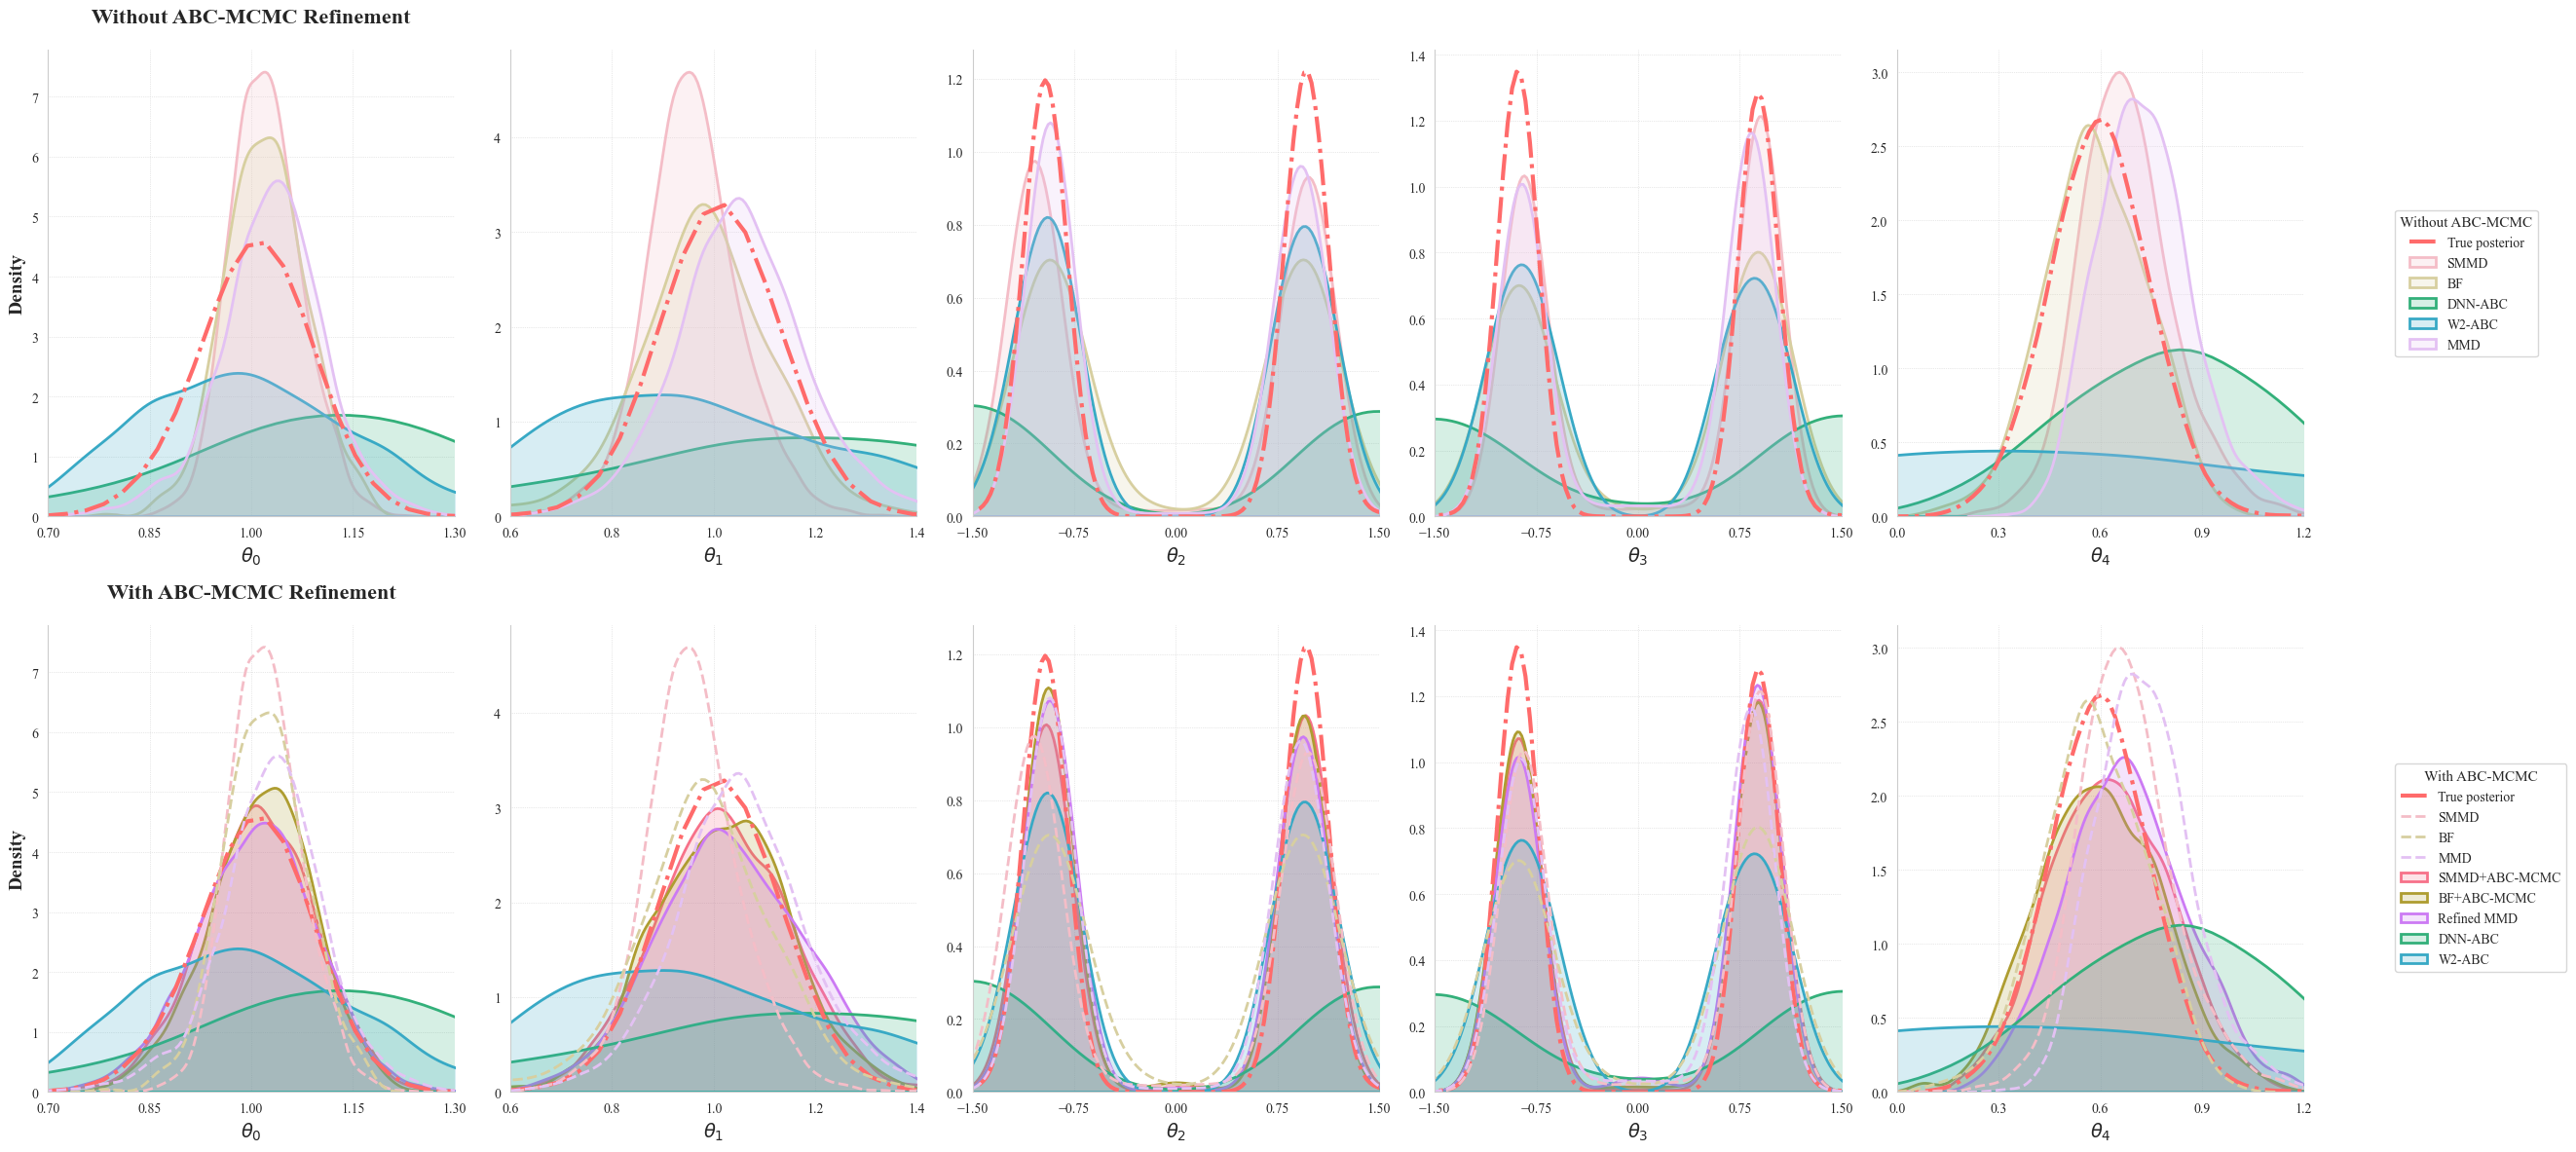

In [59]:
# --------------------------
# 统一全局样式
# --------------------------
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 10,
    'legend.labelspacing': 0.5,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

# --------------------------
# 统一配色方案（保持上下图连贯性）
# --------------------------
base_colors = sns.color_palette("husl", 5)  

# 颜色映射：未优化用浅色/虚线，优化用深色/实线
model_colors = {
    # 基础模型（上下图共用）
    "SMMD": sns.light_palette(base_colors[0])[2],
    "BF": sns.light_palette(base_colors[1])[2],
    "DNN-ABC": base_colors[2],
    "W2-ABC": base_colors[3],
    "MMD": sns.light_palette(base_colors[4])[2],
    # 优化模型（仅下图用）
    "SMMD+ABC-MCMC": base_colors[0],
    "BF+ABC-MCMC": base_colors[1],
    "MMD+ABC-MCMC": base_colors[4],
    "Refined MMD": base_colors[4]  # 与MMD+ABC-MCMC保持一致
}

# --------------------------
# 创建上下拼图布局（2行4列）
# --------------------------
fig, axs = plt.subplots(2, d, figsize=(30, 12))  # 高度加倍以容纳上下图
plt.subplots_adjust(
    wspace=0.3,  # 列间距
    hspace=0.4,  # 行间距（上下图之间）
    right=0.8    # 右侧留白给图例
)

# 参数范围（上下图保持一致）
x_limits = [
        [0.7, 1.3],  # theta_0
        [0.6, 1.4],  # theta_1
        [-1.5, 1.5],  # theta_2
        [-1.5, 1.5],  # theta_3
        [0, 1.2],  # theta_4
    ]

# 初始化所有子图的基础设置
# for i in range(2):  # 2行
#     for j in range(d):  # 4列
#         ax = axs[i, j]
#         ax.set_xlim(x_limits[j])
#         ax.set_xticks(np.linspace(x_limits[j][0], x_limits[j][1], 5))
#         ax.grid(color='lightgray', linestyle=':', linewidth=0.5)
#         sns.despine(ax=ax, top=True, right=True)
#         ax.set_xlabel(f"theta_{j}", fontweight='bold')
#         # 仅左侧列显示y轴标签
#         if j == 0:
#             ax.set_ylabel("Density", fontweight='bold')
#         else:
#             ax.set_ylabel("")

# --------------------------
# 上图：未加ABC-MCMC优化
# --------------------------
# 设置上图标题
axs[0, 0].set_title("Without ABC-MCMC Refinement", fontweight='bold', pad=20)

for j in range(d):
    ax = axs[0, j]

    sns.kdeplot(
        ps_samples[:, j],
        ax=ax,
        label="True posterior" if (j == 0) else "",
        color=truth_color,
        linestyle="-.",
        linewidth=3,
    )
    
    # SMMD
    sns.kdeplot(
        nn_ps[:, j],
        ax=ax,
        label="SMMD" if (j == 0) else "",
        color=model_colors["SMMD"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # BF
    sns.kdeplot(
        bf_ps[:, j],
        ax=ax,
        label="BF" if (j == 0) else "",
        color=model_colors["BF"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # DNN-ABC
    sns.kdeplot(
        dnnabc_ps[:, j],
        ax=ax,
        label="DNN-ABC" if (j == 0) else "",
        color=model_colors["DNN-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # W2-ABC
    sns.kdeplot(
        w2abc_ps[:, j],
        ax=ax,
        label="W2-ABC" if (j == 0) else "",
        color=model_colors["W2-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # MMD
    sns.kdeplot(
        mmd_ps[:, j],
        ax=ax,
        label="MMD" if (j == 0) else "",
        color=model_colors["MMD"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    

# --------------------------
# 下图：加ABC-MCMC优化
# --------------------------
# 设置下图标题
axs[1, 0].set_title("With ABC-MCMC Refinement", fontweight='bold', pad=20)

for j in range(d):
    ax = axs[1, j]

    sns.kdeplot(
        ps_samples[:, j],
        ax=ax,
        label="True posterior" if (j == 0) else "",
        color=truth_color,
        linestyle="-.",
        linewidth=3,
    )
    
    # 原始模型（虚线，无填充）
    sns.kdeplot(
        nn_ps[:, j],
        ax=ax,
        label="SMMD" if (j == 0) else "",
        color=model_colors["SMMD"],
        linestyle="--",
        linewidth=2,
        fill=False  # 未优化模型无填充
    )
    
    sns.kdeplot(
        bf_ps[:, j],
        ax=ax,
        label="BF" if (j == 0) else "",
        color=model_colors["BF"],
        linestyle="--",
        linewidth=2,
        fill=False
    )
    
    sns.kdeplot(
        mmd_ps[:, j],
        ax=ax,
        label="MMD" if (j == 0) else "",
        color=model_colors["MMD"],
        linestyle="--",
        linewidth=2,
        fill=False
    )
    
    # 优化模型（实线，有填充）
    sns.kdeplot(
        refined_nn_ps[:, j],
        ax=ax,
        label="SMMD+ABC-MCMC" if (j == 0) else "",
        color=model_colors["SMMD+ABC-MCMC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    sns.kdeplot(
        refined_bf_ps[:, j],
        ax=ax,
        label="BF+ABC-MCMC" if (j == 0) else "",
        color=model_colors["BF+ABC-MCMC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    sns.kdeplot(
        refined_mmd_ps[:, j],
        ax=ax,
        label="Refined MMD" if (j == 0) else "",
        color=model_colors["Refined MMD"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # 保持不变的模型（DNN-ABC和W2-ABC）
    sns.kdeplot(
        dnnabc_ps[:, j],
        ax=ax,
        label="DNN-ABC" if (j == 0) else "",
        color=model_colors["DNN-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    sns.kdeplot(
        w2abc_ps[:, j],
        ax=ax,
        label="W2-ABC" if (j == 0) else "",
        color=model_colors["W2-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
for i in range(2):  # 2行
    for j in range(d):  # 4列
        ax = axs[i, j]
        ax.set_xlim(x_limits[j])
        ax.set_xticks(np.linspace(x_limits[j][0], x_limits[j][1], 5))
        ax.grid(color='lightgray', linestyle=':', linewidth=0.5)
        sns.despine(ax=ax, top=True, right=True)
        ax.set_xlabel(f"$\\theta_{j}$", fontweight='bold')
        # 仅左侧列显示y轴标签
        if j == 0:
            ax.set_ylabel("Density", fontweight='bold')
        else:
            ax.set_ylabel("")

# --------------------------
# 分别为上下图创建独立图例
# --------------------------
# 上图图例
handles_upper, labels_upper = axs[0, 0].get_legend_handles_labels()
by_label_upper = dict(zip(labels_upper, handles_upper))
upper_legend = fig.legend(
    by_label_upper.values(), by_label_upper.keys(),
    loc='center left',
    bbox_to_anchor=(0.82, 0.75),  # 上图图例位置
    frameon=True,
    framealpha=0.9,
    edgecolor='lightgray',
    title="Without ABC-MCMC",
    title_fontsize=11,
    borderaxespad=0.5
)

# 下图图例
handles_lower, labels_lower = axs[1, 0].get_legend_handles_labels()
by_label_lower = dict(zip(labels_lower, handles_lower))
lower_legend = fig.legend(
    by_label_lower.values(), by_label_lower.keys(),
    loc='center left',
    bbox_to_anchor=(0.82, 0.25),  # 下图图例位置
    frameon=True,
    framealpha=0.9,
    edgecolor='lightgray',
    title="With ABC-MCMC",
    title_fontsize=11,
    borderaxespad=0.5
)

# 调整布局，确保所有元素可见
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.savefig(os.path.join(figure_path, "toy_example.png"), dpi=300, bbox_inches='tight')
plt.show()

## Toy Example 25

In [60]:
d = 5
n = 25  
# color setting
truth_color = "#FF6B6B"
est_color = "#4D96FF"   
refined_color = "#6BCB77"
upper_labels=["\\theta_1","\\theta_2","\\theta_3","\\theta_4","\\theta_5"]

In [61]:
model_name = ["nn", "bf", "dnnabc","w2abc"]
result_path = os.path.join(os.getcwd(), "Toy_Example_25", "result")

In [ ]:
selected_ps_indexs = [1 ,0 , 0, 0, 8]
ps_samples = np.load(os.path.join(os.getcwd(), "Toy_Example_25", "data", "ps.npy"))
nn_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_25", "result", "nn_ps", f"nn_{n}_ps_{selected_ps_indexs[0]}.npy"))
refined_nn_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_25", "result", "nn_ps", f"nn_{n}_mcmc_{selected_ps_indexs[0]}.npy"))
bf_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_25", "result", "bf_ps", f"bf_{n}_ps_{selected_ps_indexs[1]}.npy"))
refined_bf_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_25", "result", "bf_ps", f"bf_{n}_ps_mcmc_{selected_ps_indexs[1]}.npy"))
dnnabc_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_25", "result", "dnnabc_ps", f"dnnabc_ps_{selected_ps_indexs[2]}.npy"))
w2abc_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_25", "result", "w2abc_ps", f"w2_ps_{selected_ps_indexs[3]}.npy"))
mmd_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_25_MMD", "result", "nn_ps", f"nn_{n}_ps_{selected_ps_indexs[4]}.npy"))
refined_mmd_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_25_MMD", "result", "nn_ps", f"nn_{n}_mcmc_{selected_ps_indexs[4]}.npy"))

print(f"nn_ps shape: {nn_ps.shape}")
print(f"refined_nn_ps shape: {refined_nn_ps.shape}")
print(f"bf_ps shape: {bf_ps.shape}")
print(f"refined_bf_ps shape: {refined_bf_ps.shape}")
print(f"dnnabc_ps shape: {dnnabc_ps.shape}")
print(f"w2abc_ps shape: {w2abc_ps.shape}")
print(f"mmd_ps shape: {mmd_ps.shape}")
print(f"refined_mmd_ps shape: {refined_mmd_ps.shape}")

nn_ps shape: (5000, 5)
refined_nn_ps shape: (5000, 5)
bf_ps shape: (500, 5)
refined_bf_ps shape: (5000, 5)
dnnabc_ps shape: (6953, 5)
w2abc_ps shape: (4972, 5)
mmd_ps shape: (5000, 5)
refined_mmd_ps shape: (5000, 5)


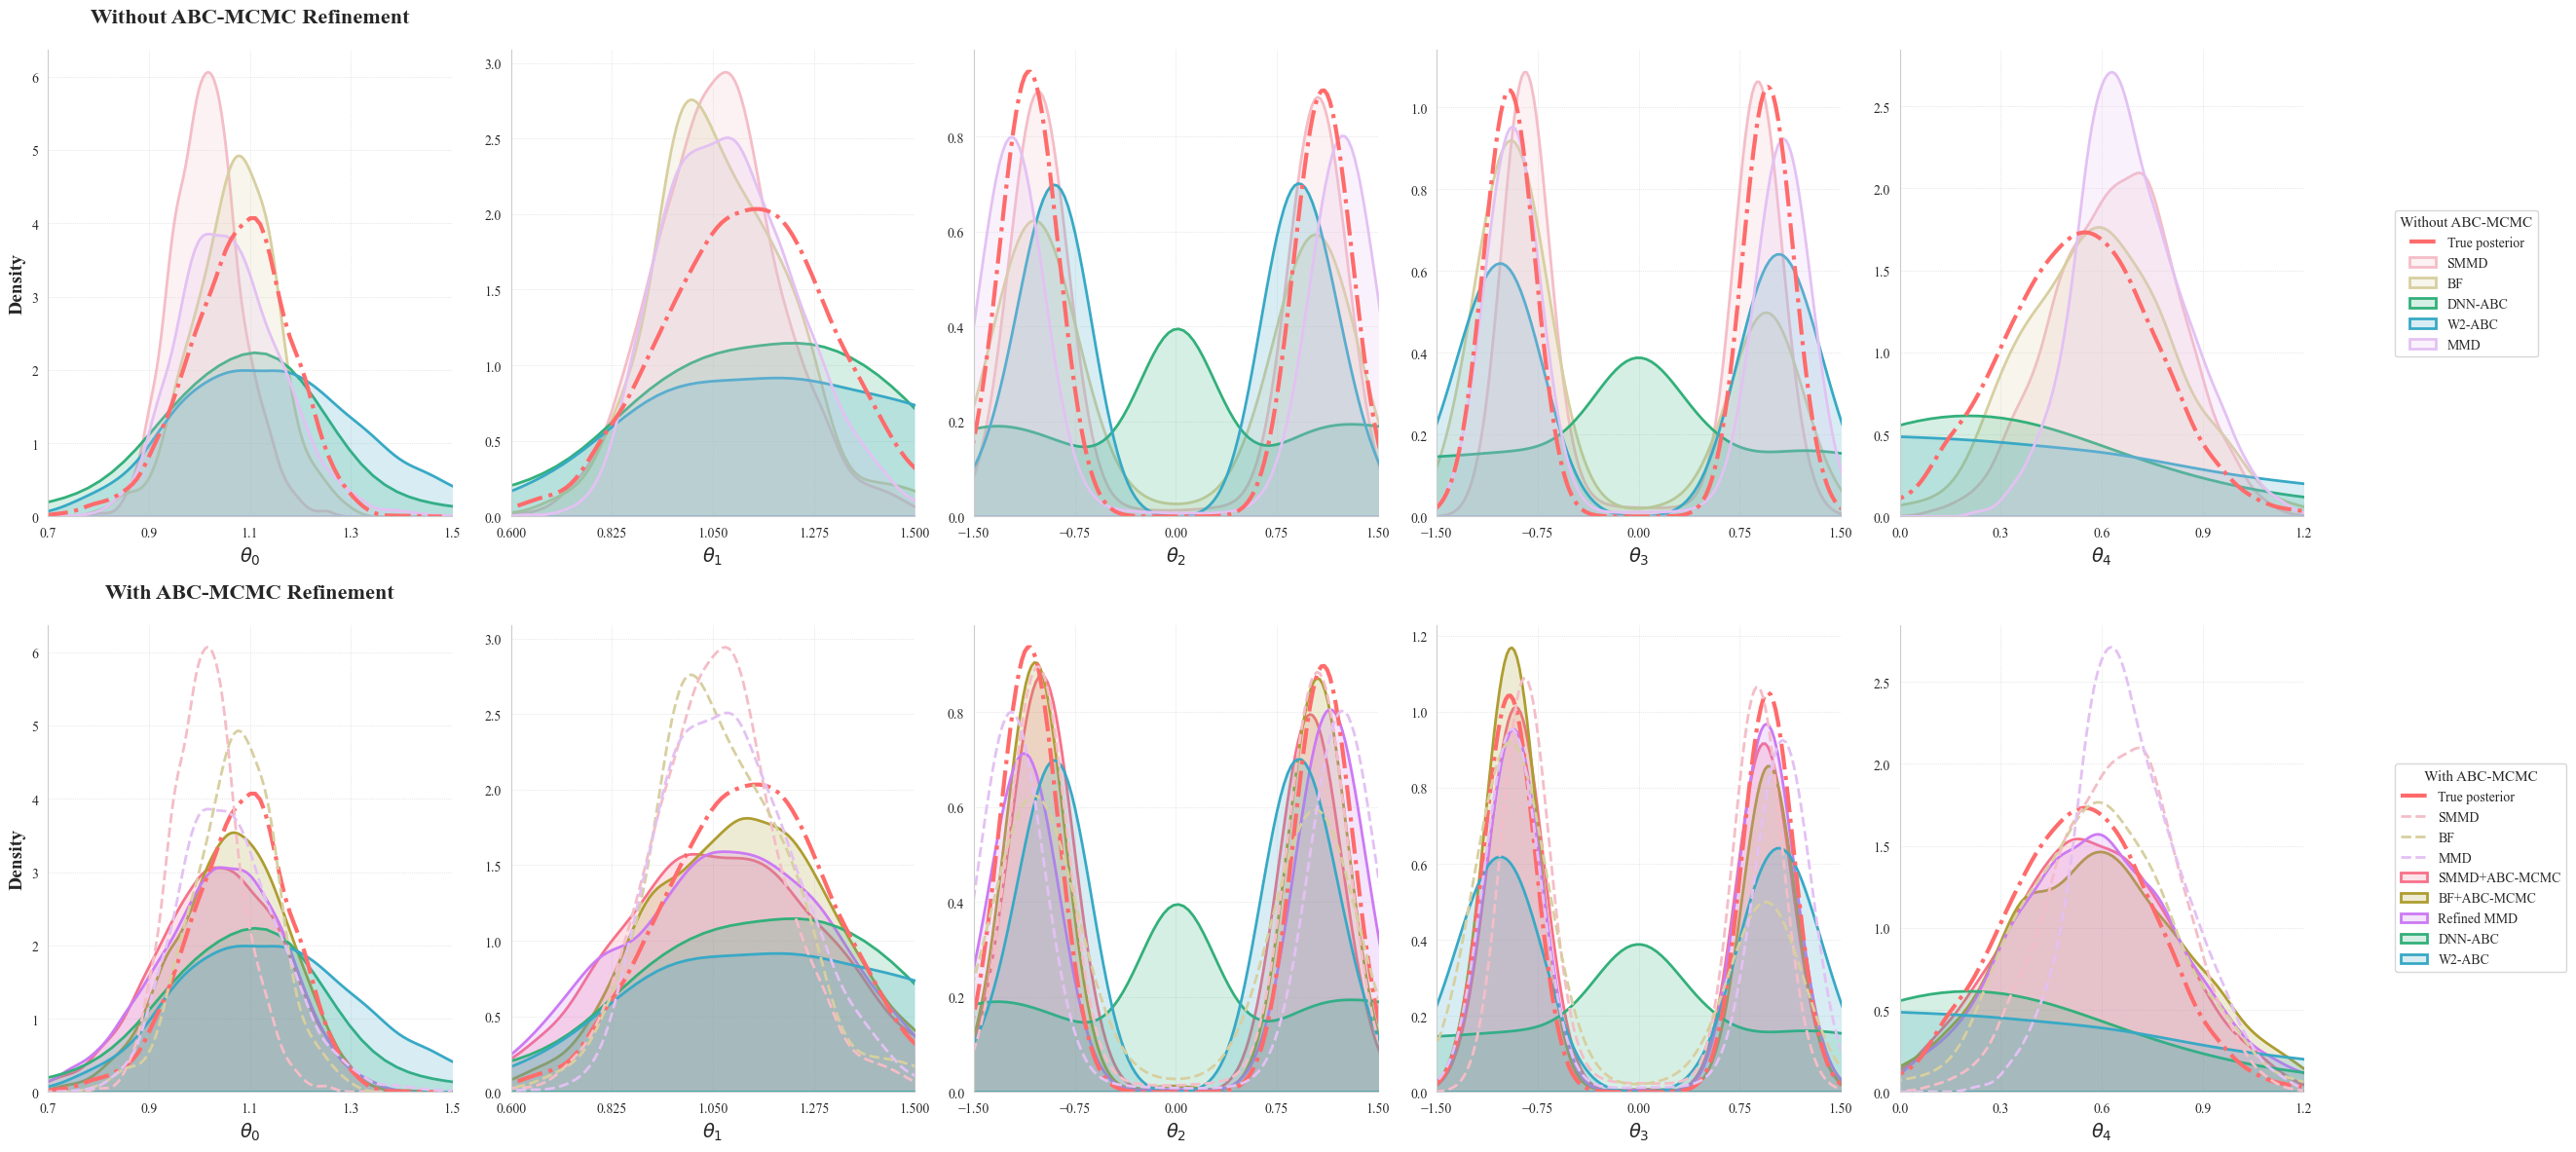

In [66]:
# --------------------------
# 统一全局样式
# --------------------------
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 10,
    'legend.labelspacing': 0.5,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

# --------------------------
# 统一配色方案（保持上下图连贯性）
# --------------------------
base_colors = sns.color_palette("husl", 5)  

# 颜色映射：未优化用浅色/虚线，优化用深色/实线
model_colors = {
    # 基础模型（上下图共用）
    "SMMD": sns.light_palette(base_colors[0])[2],
    "BF": sns.light_palette(base_colors[1])[2],
    "DNN-ABC": base_colors[2],
    "W2-ABC": base_colors[3],
    "MMD": sns.light_palette(base_colors[4])[2],
    # 优化模型（仅下图用）
    "SMMD+ABC-MCMC": base_colors[0],
    "BF+ABC-MCMC": base_colors[1],
    "MMD+ABC-MCMC": base_colors[4],
    "Refined MMD": base_colors[4]  # 与MMD+ABC-MCMC保持一致
}

# --------------------------
# 创建上下拼图布局（2行4列）
# --------------------------
fig, axs = plt.subplots(2, d, figsize=(30, 12))  # 高度加倍以容纳上下图
plt.subplots_adjust(
    wspace=0.3,  # 列间距
    hspace=0.4,  # 行间距（上下图之间）
    right=0.8    # 右侧留白给图例
)

# 参数范围（上下图保持一致）
x_limits = [
        [0.7, 1.5],  # theta_0
        [0.6, 1.5],  # theta_1
        [-1.5, 1.5],  # theta_2
        [-1.5, 1.5],  # theta_3
        [0, 1.2],  # theta_4
    ]

# 初始化所有子图的基础设置
# for i in range(2):  # 2行
#     for j in range(d):  # 4列
#         ax = axs[i, j]
#         ax.set_xlim(x_limits[j])
#         ax.set_xticks(np.linspace(x_limits[j][0], x_limits[j][1], 5))
#         ax.grid(color='lightgray', linestyle=':', linewidth=0.5)
#         sns.despine(ax=ax, top=True, right=True)
#         ax.set_xlabel(f"theta_{j}", fontweight='bold')
#         # 仅左侧列显示y轴标签
#         if j == 0:
#             ax.set_ylabel("Density", fontweight='bold')
#         else:
#             ax.set_ylabel("")

# --------------------------
# 上图：未加ABC-MCMC优化
# --------------------------
# 设置上图标题
axs[0, 0].set_title("Without ABC-MCMC Refinement", fontweight='bold', pad=20)

for j in range(d):
    ax = axs[0, j]

    sns.kdeplot(
        ps_samples[:, j],
        ax=ax,
        label="True posterior" if (j == 0) else "",
        color=truth_color,
        linestyle="-.",
        linewidth=3,
    )
    
    # SMMD
    sns.kdeplot(
        nn_ps[:, j],
        ax=ax,
        label="SMMD" if (j == 0) else "",
        color=model_colors["SMMD"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # BF
    sns.kdeplot(
        bf_ps[:, j],
        ax=ax,
        label="BF" if (j == 0) else "",
        color=model_colors["BF"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # DNN-ABC
    sns.kdeplot(
        dnnabc_ps[:, j],
        ax=ax,
        label="DNN-ABC" if (j == 0) else "",
        color=model_colors["DNN-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # W2-ABC
    sns.kdeplot(
        w2abc_ps[:, j],
        ax=ax,
        label="W2-ABC" if (j == 0) else "",
        color=model_colors["W2-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # MMD
    sns.kdeplot(
        mmd_ps[:, j],
        ax=ax,
        label="MMD" if (j == 0) else "",
        color=model_colors["MMD"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    

# --------------------------
# 下图：加ABC-MCMC优化
# --------------------------
# 设置下图标题
axs[1, 0].set_title("With ABC-MCMC Refinement", fontweight='bold', pad=20)

for j in range(d):
    ax = axs[1, j]

    sns.kdeplot(
        ps_samples[:, j],
        ax=ax,
        label="True posterior" if (j == 0) else "",
        color=truth_color,
        linestyle="-.",
        linewidth=3,
    )
    
    # 原始模型（虚线，无填充）
    sns.kdeplot(
        nn_ps[:, j],
        ax=ax,
        label="SMMD" if (j == 0) else "",
        color=model_colors["SMMD"],
        linestyle="--",
        linewidth=2,
        fill=False  # 未优化模型无填充
    )
    
    sns.kdeplot(
        bf_ps[:, j],
        ax=ax,
        label="BF" if (j == 0) else "",
        color=model_colors["BF"],
        linestyle="--",
        linewidth=2,
        fill=False
    )
    
    sns.kdeplot(
        mmd_ps[:, j],
        ax=ax,
        label="MMD" if (j == 0) else "",
        color=model_colors["MMD"],
        linestyle="--",
        linewidth=2,
        fill=False
    )
    
    # 优化模型（实线，有填充）
    sns.kdeplot(
        refined_nn_ps[:, j],
        ax=ax,
        label="SMMD+ABC-MCMC" if (j == 0) else "",
        color=model_colors["SMMD+ABC-MCMC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    sns.kdeplot(
        refined_bf_ps[:, j],
        ax=ax,
        label="BF+ABC-MCMC" if (j == 0) else "",
        color=model_colors["BF+ABC-MCMC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    sns.kdeplot(
        refined_mmd_ps[:, j],
        ax=ax,
        label="Refined MMD" if (j == 0) else "",
        color=model_colors["Refined MMD"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # 保持不变的模型（DNN-ABC和W2-ABC）
    sns.kdeplot(
        dnnabc_ps[:, j],
        ax=ax,
        label="DNN-ABC" if (j == 0) else "",
        color=model_colors["DNN-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    sns.kdeplot(
        w2abc_ps[:, j],
        ax=ax,
        label="W2-ABC" if (j == 0) else "",
        color=model_colors["W2-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
for i in range(2):  # 2行
    for j in range(d):  # 4列
        ax = axs[i, j]
        ax.set_xlim(x_limits[j])
        ax.set_xticks(np.linspace(x_limits[j][0], x_limits[j][1], 5))
        ax.grid(color='lightgray', linestyle=':', linewidth=0.5)
        sns.despine(ax=ax, top=True, right=True)
        ax.set_xlabel(f"$\\theta_{j}$", fontweight='bold')
        # 仅左侧列显示y轴标签
        if j == 0:
            ax.set_ylabel("Density", fontweight='bold')
        else:
            ax.set_ylabel("")

# --------------------------
# 分别为上下图创建独立图例
# --------------------------
# 上图图例
handles_upper, labels_upper = axs[0, 0].get_legend_handles_labels()
by_label_upper = dict(zip(labels_upper, handles_upper))
upper_legend = fig.legend(
    by_label_upper.values(), by_label_upper.keys(),
    loc='center left',
    bbox_to_anchor=(0.82, 0.75),  # 上图图例位置
    frameon=True,
    framealpha=0.9,
    edgecolor='lightgray',
    title="Without ABC-MCMC",
    title_fontsize=11,
    borderaxespad=0.5
)

# 下图图例
handles_lower, labels_lower = axs[1, 0].get_legend_handles_labels()
by_label_lower = dict(zip(labels_lower, handles_lower))
lower_legend = fig.legend(
    by_label_lower.values(), by_label_lower.keys(),
    loc='center left',
    bbox_to_anchor=(0.82, 0.25),  # 下图图例位置
    frameon=True,
    framealpha=0.9,
    edgecolor='lightgray',
    title="With ABC-MCMC",
    title_fontsize=11,
    borderaxespad=0.5
)

# 调整布局，确保所有元素可见
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.savefig(os.path.join(figure_path, "toy_example_25.png"), dpi=300, bbox_inches='tight')
plt.show()

## Toy Example 100

In [69]:
d = 5
n = 100 
# color setting
truth_color = "#FF6B6B"
est_color = "#4D96FF"   
refined_color = "#6BCB77"
upper_labels=["\\theta_1","\\theta_2","\\theta_3","\\theta_4","\\theta_5"]


In [70]:
selected_ps_indexs = [1 ,0 , 0, 0, 10]
ps_samples = np.load(os.path.join(os.getcwd(), "Toy_Example_100", "data", "ps.npy"))
nn_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_100", "result", "nn_ps", f"nn_{n}_ps_{selected_ps_indexs[0]}.npy"))
refined_nn_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_100", "result", "nn_ps", f"nn_{n}_mcmc_{selected_ps_indexs[0]}.npy"))
bf_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_100", "result", "bf_ps", f"bf_{n}_ps_{selected_ps_indexs[1]}.npy"))
refined_bf_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_100", "result", "bf_ps", f"bf_{n}_ps_mcmc_{selected_ps_indexs[1]}.npy"))
dnnabc_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_100", "result", "dnnabc_ps", f"dnnabc_ps_{selected_ps_indexs[2]}.npy"))
w2abc_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_100", "result", "w2abc_ps", f"w2_ps_{selected_ps_indexs[3]}.npy"))
mmd_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_100_MMD", "result", "nn_ps", f"nn_{n}_ps_{selected_ps_indexs[4]}.npy"))
refined_mmd_ps = np.load(os.path.join(os.getcwd(), "Toy_Example_100_MMD", "result", "nn_ps", f"nn_{n}_mcmc_{selected_ps_indexs[4]}.npy"))

print(f"nn_ps shape: {nn_ps.shape}")
print(f"refined_nn_ps shape: {refined_nn_ps.shape}")
print(f"bf_ps shape: {bf_ps.shape}")
print(f"refined_bf_ps shape: {refined_bf_ps.shape}")
print(f"dnnabc_ps shape: {dnnabc_ps.shape}")
print(f"w2abc_ps shape: {w2abc_ps.shape}")
print(f"mmd_ps shape: {mmd_ps.shape}")
print(f"refined_mmd_ps shape: {refined_mmd_ps.shape}")

nn_ps shape: (5000, 5)
refined_nn_ps shape: (5000, 5)
bf_ps shape: (500, 5)
refined_bf_ps shape: (5000, 5)
dnnabc_ps shape: (1936, 5)
w2abc_ps shape: (5435, 5)
mmd_ps shape: (5000, 5)
refined_mmd_ps shape: (5000, 5)


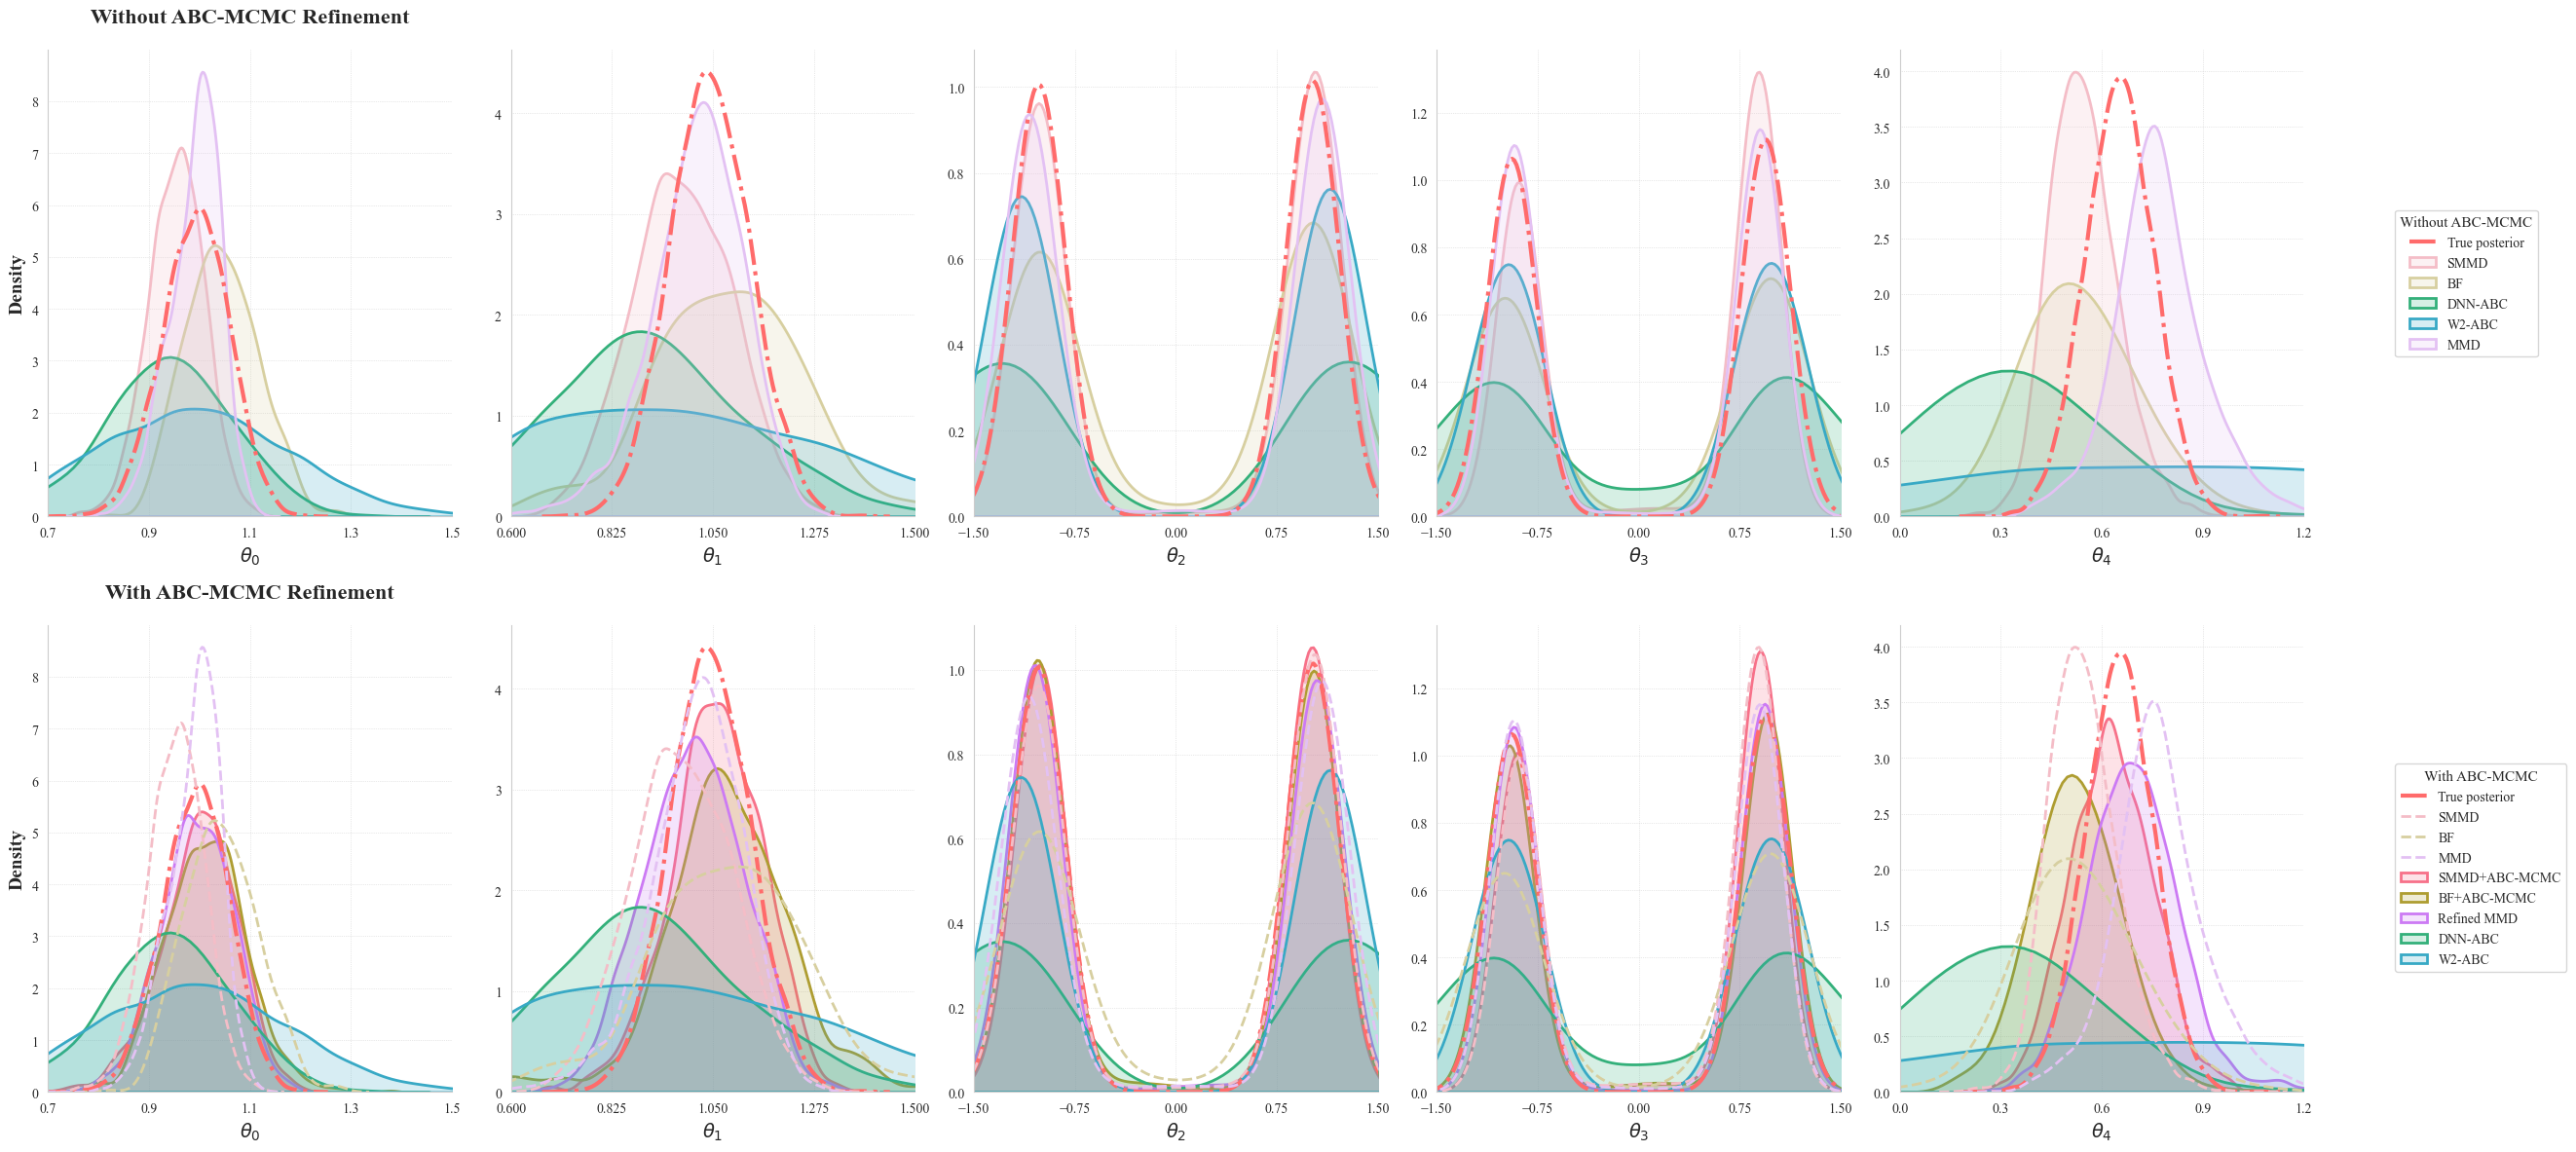

In [71]:
# --------------------------
# 统一全局样式
# --------------------------
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 10,
    'legend.labelspacing': 0.5,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

# --------------------------
# 统一配色方案（保持上下图连贯性）
# --------------------------
base_colors = sns.color_palette("husl", 5)  

# 颜色映射：未优化用浅色/虚线，优化用深色/实线
model_colors = {
    # 基础模型（上下图共用）
    "SMMD": sns.light_palette(base_colors[0])[2],
    "BF": sns.light_palette(base_colors[1])[2],
    "DNN-ABC": base_colors[2],
    "W2-ABC": base_colors[3],
    "MMD": sns.light_palette(base_colors[4])[2],
    # 优化模型（仅下图用）
    "SMMD+ABC-MCMC": base_colors[0],
    "BF+ABC-MCMC": base_colors[1],
    "MMD+ABC-MCMC": base_colors[4],
    "Refined MMD": base_colors[4]  # 与MMD+ABC-MCMC保持一致
}

# --------------------------
# 创建上下拼图布局（2行4列）
# --------------------------
fig, axs = plt.subplots(2, d, figsize=(30, 12))  # 高度加倍以容纳上下图
plt.subplots_adjust(
    wspace=0.3,  # 列间距
    hspace=0.4,  # 行间距（上下图之间）
    right=0.8    # 右侧留白给图例
)

# 参数范围（上下图保持一致）
x_limits = [
        [0.7, 1.5],  # theta_0
        [0.6, 1.5],  # theta_1
        [-1.5, 1.5],  # theta_2
        [-1.5, 1.5],  # theta_3
        [0, 1.2],  # theta_4
    ]

# 初始化所有子图的基础设置
# for i in range(2):  # 2行
#     for j in range(d):  # 4列
#         ax = axs[i, j]
#         ax.set_xlim(x_limits[j])
#         ax.set_xticks(np.linspace(x_limits[j][0], x_limits[j][1], 5))
#         ax.grid(color='lightgray', linestyle=':', linewidth=0.5)
#         sns.despine(ax=ax, top=True, right=True)
#         ax.set_xlabel(f"theta_{j}", fontweight='bold')
#         # 仅左侧列显示y轴标签
#         if j == 0:
#             ax.set_ylabel("Density", fontweight='bold')
#         else:
#             ax.set_ylabel("")

# --------------------------
# 上图：未加ABC-MCMC优化
# --------------------------
# 设置上图标题
axs[0, 0].set_title("Without ABC-MCMC Refinement", fontweight='bold', pad=20)

for j in range(d):
    ax = axs[0, j]

    sns.kdeplot(
        ps_samples[:, j],
        ax=ax,
        label="True posterior" if (j == 0) else "",
        color=truth_color,
        linestyle="-.",
        linewidth=3,
    )
    
    # SMMD
    sns.kdeplot(
        nn_ps[:, j],
        ax=ax,
        label="SMMD" if (j == 0) else "",
        color=model_colors["SMMD"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # BF
    sns.kdeplot(
        bf_ps[:, j],
        ax=ax,
        label="BF" if (j == 0) else "",
        color=model_colors["BF"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # DNN-ABC
    sns.kdeplot(
        dnnabc_ps[:, j],
        ax=ax,
        label="DNN-ABC" if (j == 0) else "",
        color=model_colors["DNN-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # W2-ABC
    sns.kdeplot(
        w2abc_ps[:, j],
        ax=ax,
        label="W2-ABC" if (j == 0) else "",
        color=model_colors["W2-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # MMD
    sns.kdeplot(
        mmd_ps[:, j],
        ax=ax,
        label="MMD" if (j == 0) else "",
        color=model_colors["MMD"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    

# --------------------------
# 下图：加ABC-MCMC优化
# --------------------------
# 设置下图标题
axs[1, 0].set_title("With ABC-MCMC Refinement", fontweight='bold', pad=20)

for j in range(d):
    ax = axs[1, j]

    sns.kdeplot(
        ps_samples[:, j],
        ax=ax,
        label="True posterior" if (j == 0) else "",
        color=truth_color,
        linestyle="-.",
        linewidth=3,
    )
    
    # 原始模型（虚线，无填充）
    sns.kdeplot(
        nn_ps[:, j],
        ax=ax,
        label="SMMD" if (j == 0) else "",
        color=model_colors["SMMD"],
        linestyle="--",
        linewidth=2,
        fill=False  # 未优化模型无填充
    )
    
    sns.kdeplot(
        bf_ps[:, j],
        ax=ax,
        label="BF" if (j == 0) else "",
        color=model_colors["BF"],
        linestyle="--",
        linewidth=2,
        fill=False
    )
    
    sns.kdeplot(
        mmd_ps[:, j],
        ax=ax,
        label="MMD" if (j == 0) else "",
        color=model_colors["MMD"],
        linestyle="--",
        linewidth=2,
        fill=False
    )
    
    # 优化模型（实线，有填充）
    sns.kdeplot(
        refined_nn_ps[:, j],
        ax=ax,
        label="SMMD+ABC-MCMC" if (j == 0) else "",
        color=model_colors["SMMD+ABC-MCMC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    sns.kdeplot(
        refined_bf_ps[:, j],
        ax=ax,
        label="BF+ABC-MCMC" if (j == 0) else "",
        color=model_colors["BF+ABC-MCMC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    sns.kdeplot(
        refined_mmd_ps[:, j],
        ax=ax,
        label="Refined MMD" if (j == 0) else "",
        color=model_colors["Refined MMD"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # 保持不变的模型（DNN-ABC和W2-ABC）
    sns.kdeplot(
        dnnabc_ps[:, j],
        ax=ax,
        label="DNN-ABC" if (j == 0) else "",
        color=model_colors["DNN-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    sns.kdeplot(
        w2abc_ps[:, j],
        ax=ax,
        label="W2-ABC" if (j == 0) else "",
        color=model_colors["W2-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
for i in range(2):  # 2行
    for j in range(d):  # 4列
        ax = axs[i, j]
        ax.set_xlim(x_limits[j])
        ax.set_xticks(np.linspace(x_limits[j][0], x_limits[j][1], 5))
        ax.grid(color='lightgray', linestyle=':', linewidth=0.5)
        sns.despine(ax=ax, top=True, right=True)
        ax.set_xlabel(f"$\\theta_{j}$", fontweight='bold')
        # 仅左侧列显示y轴标签
        if j == 0:
            ax.set_ylabel("Density", fontweight='bold')
        else:
            ax.set_ylabel("")

# --------------------------
# 分别为上下图创建独立图例
# --------------------------
# 上图图例
handles_upper, labels_upper = axs[0, 0].get_legend_handles_labels()
by_label_upper = dict(zip(labels_upper, handles_upper))
upper_legend = fig.legend(
    by_label_upper.values(), by_label_upper.keys(),
    loc='center left',
    bbox_to_anchor=(0.82, 0.75),  # 上图图例位置
    frameon=True,
    framealpha=0.9,
    edgecolor='lightgray',
    title="Without ABC-MCMC",
    title_fontsize=11,
    borderaxespad=0.5
)

# 下图图例
handles_lower, labels_lower = axs[1, 0].get_legend_handles_labels()
by_label_lower = dict(zip(labels_lower, handles_lower))
lower_legend = fig.legend(
    by_label_lower.values(), by_label_lower.keys(),
    loc='center left',
    bbox_to_anchor=(0.82, 0.25),  # 下图图例位置
    frameon=True,
    framealpha=0.9,
    edgecolor='lightgray',
    title="With ABC-MCMC",
    title_fontsize=11,
    borderaxespad=0.5
)

# 调整布局，确保所有元素可见
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.savefig(os.path.join(figure_path, "toy_example_100.png"), dpi=300, bbox_inches='tight')
plt.show()

## Lotka Volterra Model

In [29]:
d = 4
true_ps = np.log(np.array([1, 0.01, 0.5, 0.01]))
true_ps_tf = tf.convert_to_tensor(true_ps, dtype=tf.float32)
true_ps_ls = true_ps.tolist()

base_colors = sns.color_palette("husl", 5)
truth_color = "#FF6B6B"
est_color = "#4D96FF"
refined_color = "#6BCB77"
upper_labels=["\\theta_1","\\theta_2","\\theta_3","\\theta_4"]

In [30]:
model_name = ["nn", "bf", "dnnabc","w2abc"]
result_path = os.path.join(os.getcwd(),'lotka_volterra', 'result')

In [31]:
selected_ps_indexs = [0, 0, 0, 0, 0]  
nn_ps = np.load(os.path.join(result_path,"nn_ps", f"lv_nn_ps_{selected_ps_indexs[0]}.npy" ))
refined_nn_ps= np.load(os.path.join(result_path,"nn_ps", f"lv_nn_mcmc_{selected_ps_indexs[0]}.npy" ))
bf_ps = np.load(os.path.join(result_path,"bf_ps", f"bf_lv_ps_{selected_ps_indexs[1]}.npy" ))
refined_bf_ps = np.load(os.path.join(result_path,"bf_ps", f"bf_lv_mcmc_{selected_ps_indexs[1]}.npy" ))
dnnabc_ps = np.load(os.path.join(result_path,"dnnabc_ps", f"dnnabc_ps_{selected_ps_indexs[2]}.npy" ))
w2abc_ps = np.load(os.path.join(result_path,"w2abc_ps", f"w2abc_ps_{selected_ps_indexs[3]}.npy" ))

mmd_ps = np.load(os.path.join(os.getcwd(), "lotka_volterra_mmd", "result", "nn_ps", f"lv_nn_ps_{selected_ps_indexs[0]}.npy"))
refined_mmd_ps = np.load(os.path.join(os.getcwd(), "lotka_volterra_mmd", "result", "nn_ps", f"lv_nn_mcmc_{selected_ps_indexs[0]}.npy"))

print(f"nn_ps shape: {nn_ps.shape}")
print(f"refined_nn_ps shape: {refined_nn_ps.shape}")
print(f"bf_ps shape: {bf_ps.shape}")
print(f"refined_bf_ps shape: {refined_bf_ps.shape}")
print(f"dnnabc_ps shape: {dnnabc_ps.shape}")
print(f"w2abc_ps shape: {w2abc_ps.shape}")
print(f"mmd_ps shape: {mmd_ps.shape}")
print(f"refined_mmd_ps shape: {refined_mmd_ps.shape}")


nn_ps shape: (500, 4)
refined_nn_ps shape: (500, 4)
bf_ps shape: (500, 4)
refined_bf_ps shape: (500, 4)
dnnabc_ps shape: (1331, 4)
w2abc_ps shape: (445, 4)
mmd_ps shape: (500, 4)
refined_mmd_ps shape: (500, 4)


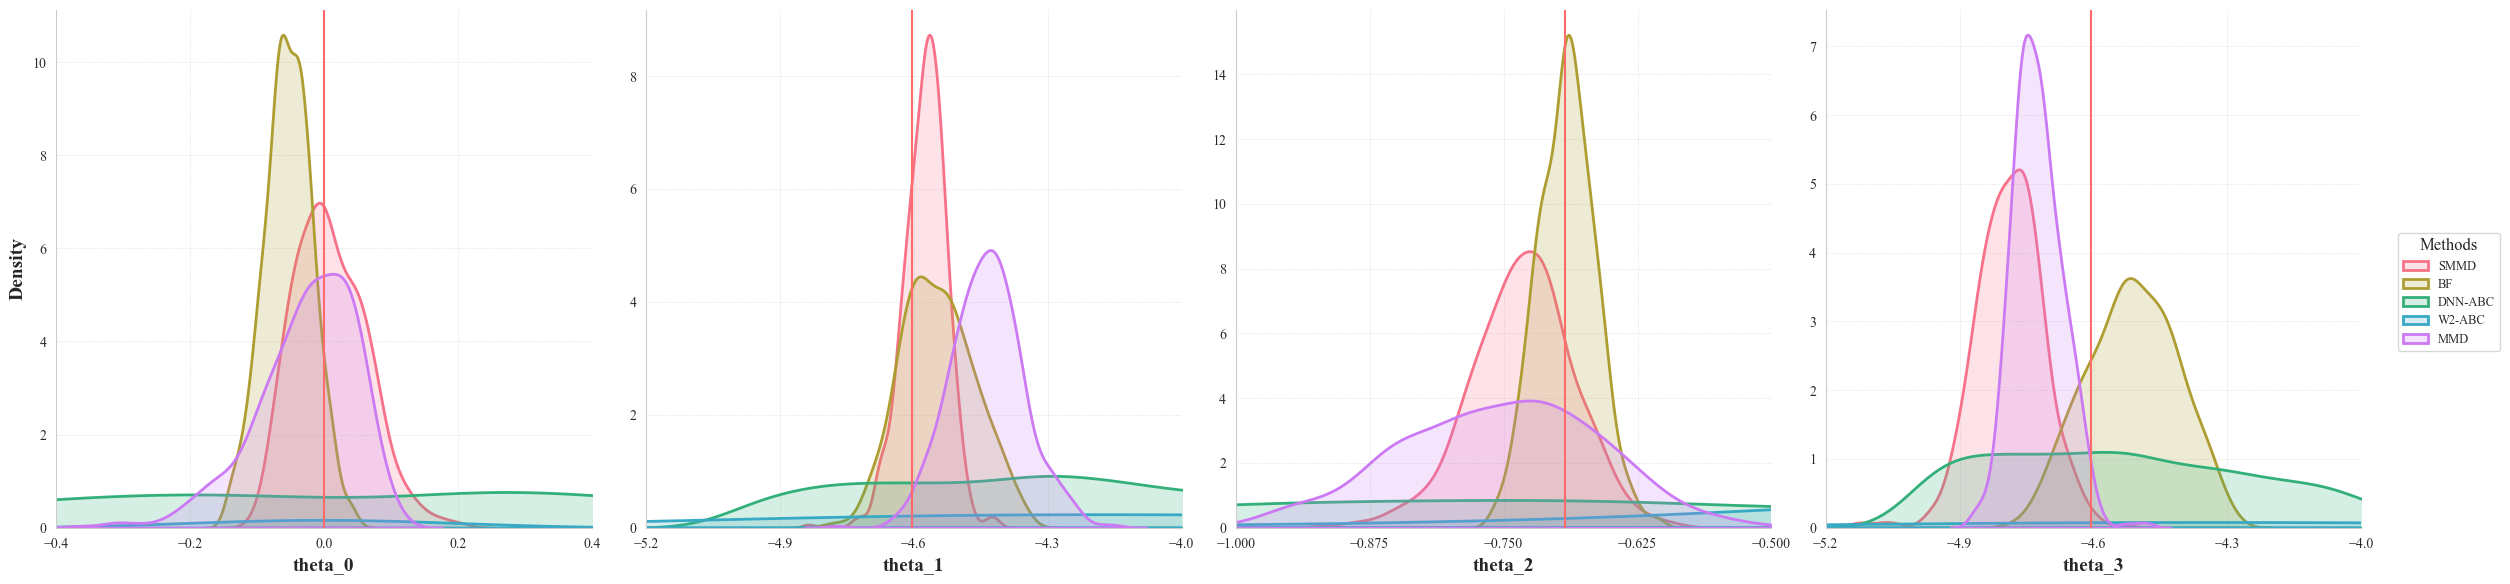

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 统一全局样式
# --------------------------
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 9,  # 稍微减小图例字体
    'legend.labelspacing': 0.5,  # 减小图例项之间的间距
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

# --------------------------
# 定义颜色方案
# --------------------------

model_colors = {
    "SMMD": base_colors[0],
    "BF": base_colors[1],
    "DNN-ABC": base_colors[2],
    "W2-ABC": base_colors[3],
    "MMD": base_colors[4],
}

# --------------------------
# 创建子图布局 - 为图例预留更多空间
# --------------------------
fig, axs = plt.subplots(1, 4, figsize=(30, 6))
# 调整右侧边距，为图例留出更多空间
plt.subplots_adjust(wspace=0.3, right=0.8)  # 减小right值，给右侧图例更多空间

# 参数范围设置
x_limits = [
    [-0.4, 0.4],   # theta_0
    [-5.2, -4.0],  # theta_1
    [-1.0, -0.5],  # theta_2
    [-5.2, -4.0],  # theta_3
]

# 设置每个子图的x轴范围、网格和边框
for j, ax in enumerate(axs):
    ax.set_xlim(x_limits[j])
    ax.set_xticks(np.linspace(x_limits[j][0], x_limits[j][1], 5))
    ax.grid(color='lightgray', linestyle=':', linewidth=0.5)
    sns.despine(ax=ax, top=True, right=True)

# --------------------------
# 绘制KDE曲线（假设数据变量已定义）
# --------------------------
# 注意：这里需要确保nn_ps, refined_nn_ps等数据变量已定义
for j in range(len(axs)):
    # 1. SMMD（实线+主色1）
    sns.kdeplot(
        nn_ps[:, j],
        ax=axs[j],
        label="SMMD" if j == 0 else "",
        color=model_colors["SMMD"],
        linestyle="-",
        linewidth=2,  # 稍加粗增强视觉权重
        fill=True,  # 添加填充以增强视觉效果
        alpha=0.2,  # 轻微透明度
    )
    

    # 3. BF（实线+主色2）
    sns.kdeplot(
        bf_ps[:, j],
        ax=axs[j],
        label="BF" if j == 0 else "",
        color=model_colors["BF"],
        linestyle="-",
        linewidth=2,
        fill=True,  # 添加填充以增强视觉效果
        alpha=0.2,  # 轻微透明度
    )

    
    # 5. DNN-ABC（实线+主色3）
    sns.kdeplot(
        dnnabc_ps[:, j],
        ax=axs[j],
        label="DNN-ABC" if j == 0 else "",
        color=model_colors["DNN-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,  # 添加填充以增强视觉效果
        alpha=0.2,  # 轻微透明度
    )

    # 6. W2-ABC（实线+主色4）
    sns.kdeplot(
        w2abc_ps[:, j],
        ax=axs[j],
        label="W2-ABC" if j == 0 else "",
        color=model_colors["W2-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,  # 添加填充以增强视觉效果
        alpha=0.2,  # 轻微透明度

    )

    sns.kdeplot(
        mmd_ps[:, j],
        ax=axs[j],
        label="MMD" if j == 0 else "",
        color=model_colors["MMD"],
        linestyle="-",
        linewidth=2,
        fill=True,  # 添加填充以增强视觉效果
        alpha=0.2,  # 轻微透明度
    )

    # 子图标题和标签
    axs[j].set_xlabel(f"theta_{j}", fontweight='bold')
    if j == 0:
        axs[j].set_ylabel("Density", fontweight='bold')
    else:
        axs[j].set_ylabel("")


for ax, true_p in zip(axs, true_ps_ls):
        ax.axvline(true_p, color=truth_color, linestyle="-", linewidth=1.5)

# --------------------------
# 优化图例位置和大小
# --------------------------
handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# 将图例放在更右侧，完全在图像外部
fig.legend(
    by_label.values(), by_label.keys(),
    loc='center left', 
    bbox_to_anchor=(0.8, 0.5),  # 调整水平位置，使其远离子图
    frameon=True, 
    framealpha=0.9, 
    edgecolor='lightgray',
    title="Methods", 
    title_fontsize=12,
    borderaxespad=0.5  # 调整图例与轴的距离
)

# 使用tight_layout但避免影响图例位置
plt.tight_layout(rect=[0, 0, 0.8, 1])  # 限制tight_layout的作用范围，为图例留出空间
plt.show()

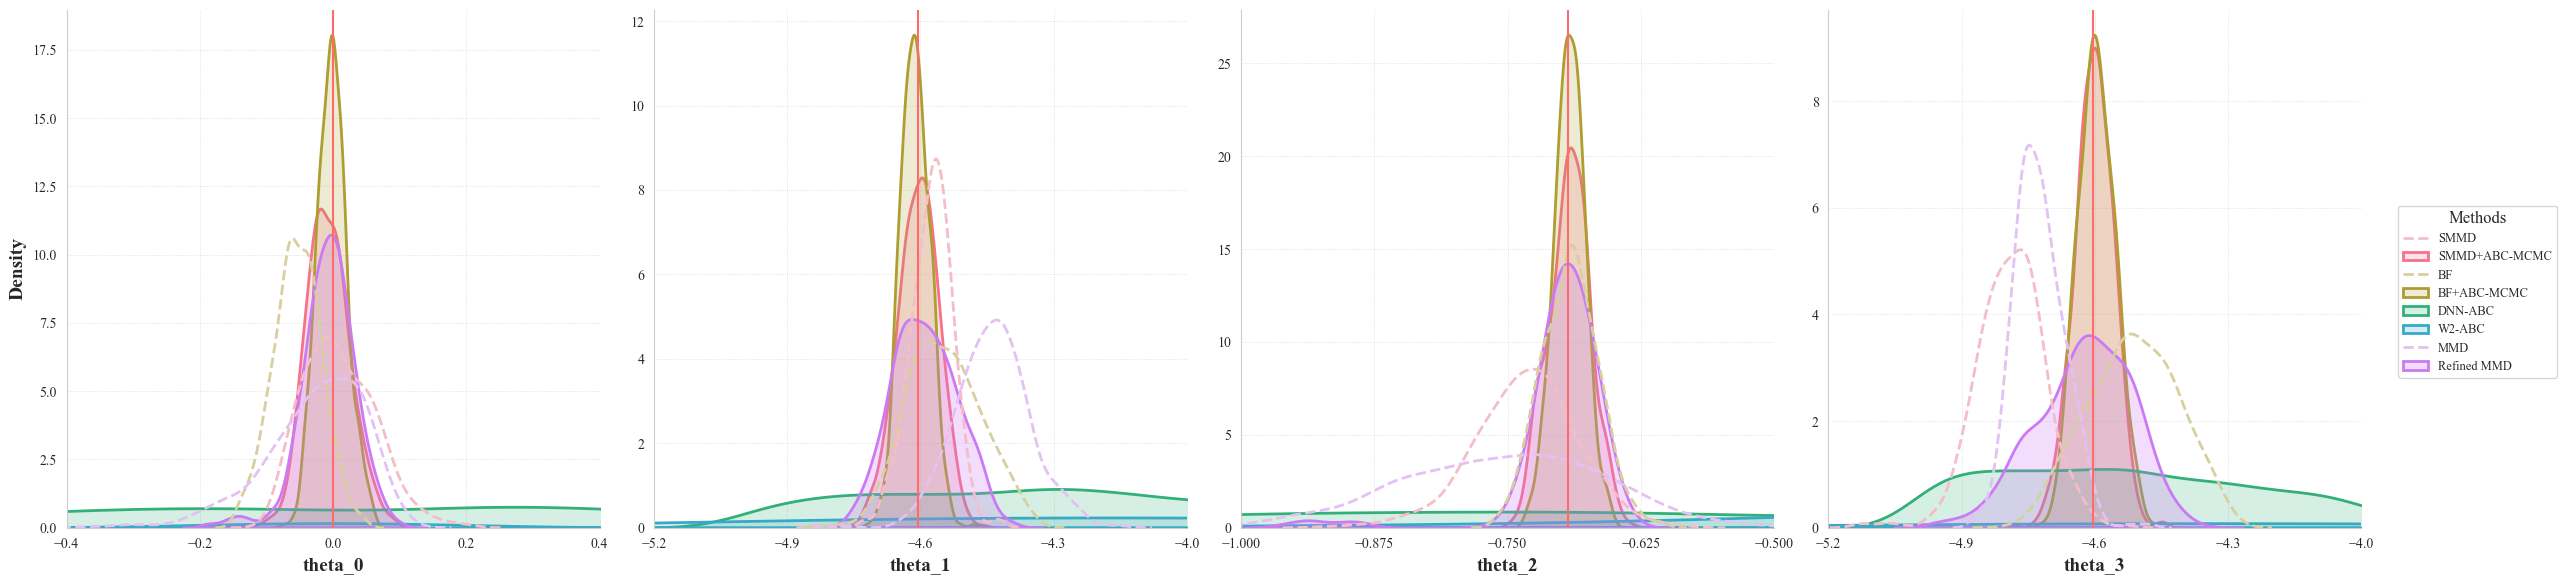

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 统一全局样式
# --------------------------
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 9,  # 稍微减小图例字体
    'legend.labelspacing': 0.5,  # 减小图例项之间的间距
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

# --------------------------
# 定义颜色方案
# --------------------------
base_colors = sns.color_palette("husl", 5)

model_colors = {
    "SMMD": sns.light_palette(base_colors[0])[2],
    "SMMD+ABC-MCMC": base_colors[0],
    "BF": sns.light_palette(base_colors[1])[2],
    "BF+ABC-MCMC": base_colors[1],
    "MMD": sns.light_palette(base_colors[4])[2],
    "MMD+ABC-MCMC": base_colors[4],
    "DNN-ABC": base_colors[2],
    "W2-ABC": base_colors[3],
}

# --------------------------
# 创建子图布局 - 为图例预留更多空间
# --------------------------
fig, axs = plt.subplots(1, 4, figsize=(30, 6))
# 调整右侧边距，为图例留出更多空间
plt.subplots_adjust(wspace=0.3, right=0.8)  # 减小right值，给右侧图例更多空间

# 参数范围设置
x_limits = [
    [-0.4, 0.4],   # theta_0
    [-5.2, -4.0],  # theta_1
    [-1.0, -0.5],  # theta_2
    [-5.2, -4.0],  # theta_3
]

# 设置每个子图的x轴范围、网格和边框
for j, ax in enumerate(axs):
    ax.set_xlim(x_limits[j])
    ax.set_xticks(np.linspace(x_limits[j][0], x_limits[j][1], 5))
    ax.grid(color='lightgray', linestyle=':', linewidth=0.5)
    sns.despine(ax=ax, top=True, right=True)

# --------------------------
# 绘制KDE曲线（假设数据变量已定义）
# --------------------------
# 注意：这里需要确保nn_ps, refined_nn_ps等数据变量已定义
for j in range(len(axs)):
    # 1. SMMD（实线+主色1）
    sns.kdeplot(
        nn_ps[:, j],
        ax=axs[j],
        label="SMMD" if j == 0 else "",
        color=model_colors["SMMD"],
        linestyle="--",
        linewidth=2,  # 稍加粗增强视觉权重
    )
    
    # 2. SMMD+ABC-MCMC（虚线+同色系浅色1）
    sns.kdeplot(
        refined_nn_ps[:, j],
        ax=axs[j],
        label="SMMD+ABC-MCMC" if j == 0 else "",
        color=model_colors["SMMD+ABC-MCMC"],
        linestyle="-",
        linewidth=2,
        fill=True,  # 添加填充以增强视觉效果
        alpha=0.2,  # 轻微透明度
    )

    # 3. BF（实线+主色2）
    sns.kdeplot(
        bf_ps[:, j],
        ax=axs[j],
        label="BF" if j == 0 else "",
        color=model_colors["BF"],
        linestyle="--",
        linewidth=2,
    )

    # 4. BF+ABC-MCMC（虚线+同色系浅色2）
    sns.kdeplot(
        refined_bf_ps[:, j],
        ax=axs[j],
        label="BF+ABC-MCMC" if j == 0 else "",
        color=model_colors["BF+ABC-MCMC"],
        linestyle="-",
        linewidth=2,
        fill=True,  # 添加填充以增强视觉效果
        alpha=0.2,  # 轻微透明度
    )
    
    # 5. DNN-ABC（实线+主色3）
    sns.kdeplot(
        dnnabc_ps[:, j],
        ax=axs[j],
        label="DNN-ABC" if j == 0 else "",
        color=model_colors["DNN-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,  # 添加填充以增强视觉效果
        alpha=0.2,  # 轻微透明度
    )

    # 6. W2-ABC（实线+主色4）
    sns.kdeplot(
        w2abc_ps[:, j],
        ax=axs[j],
        label="W2-ABC" if j == 0 else "",
        color=model_colors["W2-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,  # 添加填充以增强视觉效果
        alpha=0.2,  # 轻微透明度
    )

    sns.kdeplot(
        mmd_ps[:, j],
        ax=axs[j],
        label="MMD" if j == 0 else "",
        color=model_colors["MMD"],
        linestyle="--",
        linewidth=2,
    )

    sns.kdeplot(
        refined_mmd_ps[:, j],
        ax=axs[j],
        label="Refined MMD" if j == 0 else "",
        color=model_colors["MMD+ABC-MCMC"],
        linestyle="-",
        linewidth=2,
        fill=True,  # 添加填充以增强视觉效果
    )


    # 子图标题和标签
    axs[j].set_xlabel(f"theta_{j}", fontweight='bold')
    if j == 0:
        axs[j].set_ylabel("Density", fontweight='bold')
    else:
        axs[j].set_ylabel("")

for ax, true_p in zip(axs, true_ps_ls):
        ax.axvline(true_p, color=truth_color, linestyle="-", linewidth=1.5)

# --------------------------
# 优化图例位置和大小
# --------------------------
handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# 将图例放在更右侧，完全在图像外部
fig.legend(
    by_label.values(), by_label.keys(),
    loc='center left', 
    bbox_to_anchor=(0.8, 0.5),  # 调整水平位置，使其远离子图
    frameon=True, 
    framealpha=0.9, 
    edgecolor='lightgray',
    title="Methods", 
    title_fontsize=12,
    borderaxespad=0.5  # 调整图例与轴的距离
)

# 使用tight_layout但避免影响图例位置
plt.tight_layout(rect=[0, 0, 0.8, 1])  # 限制tight_layout的作用范围，为图例留出空间
plt.show()

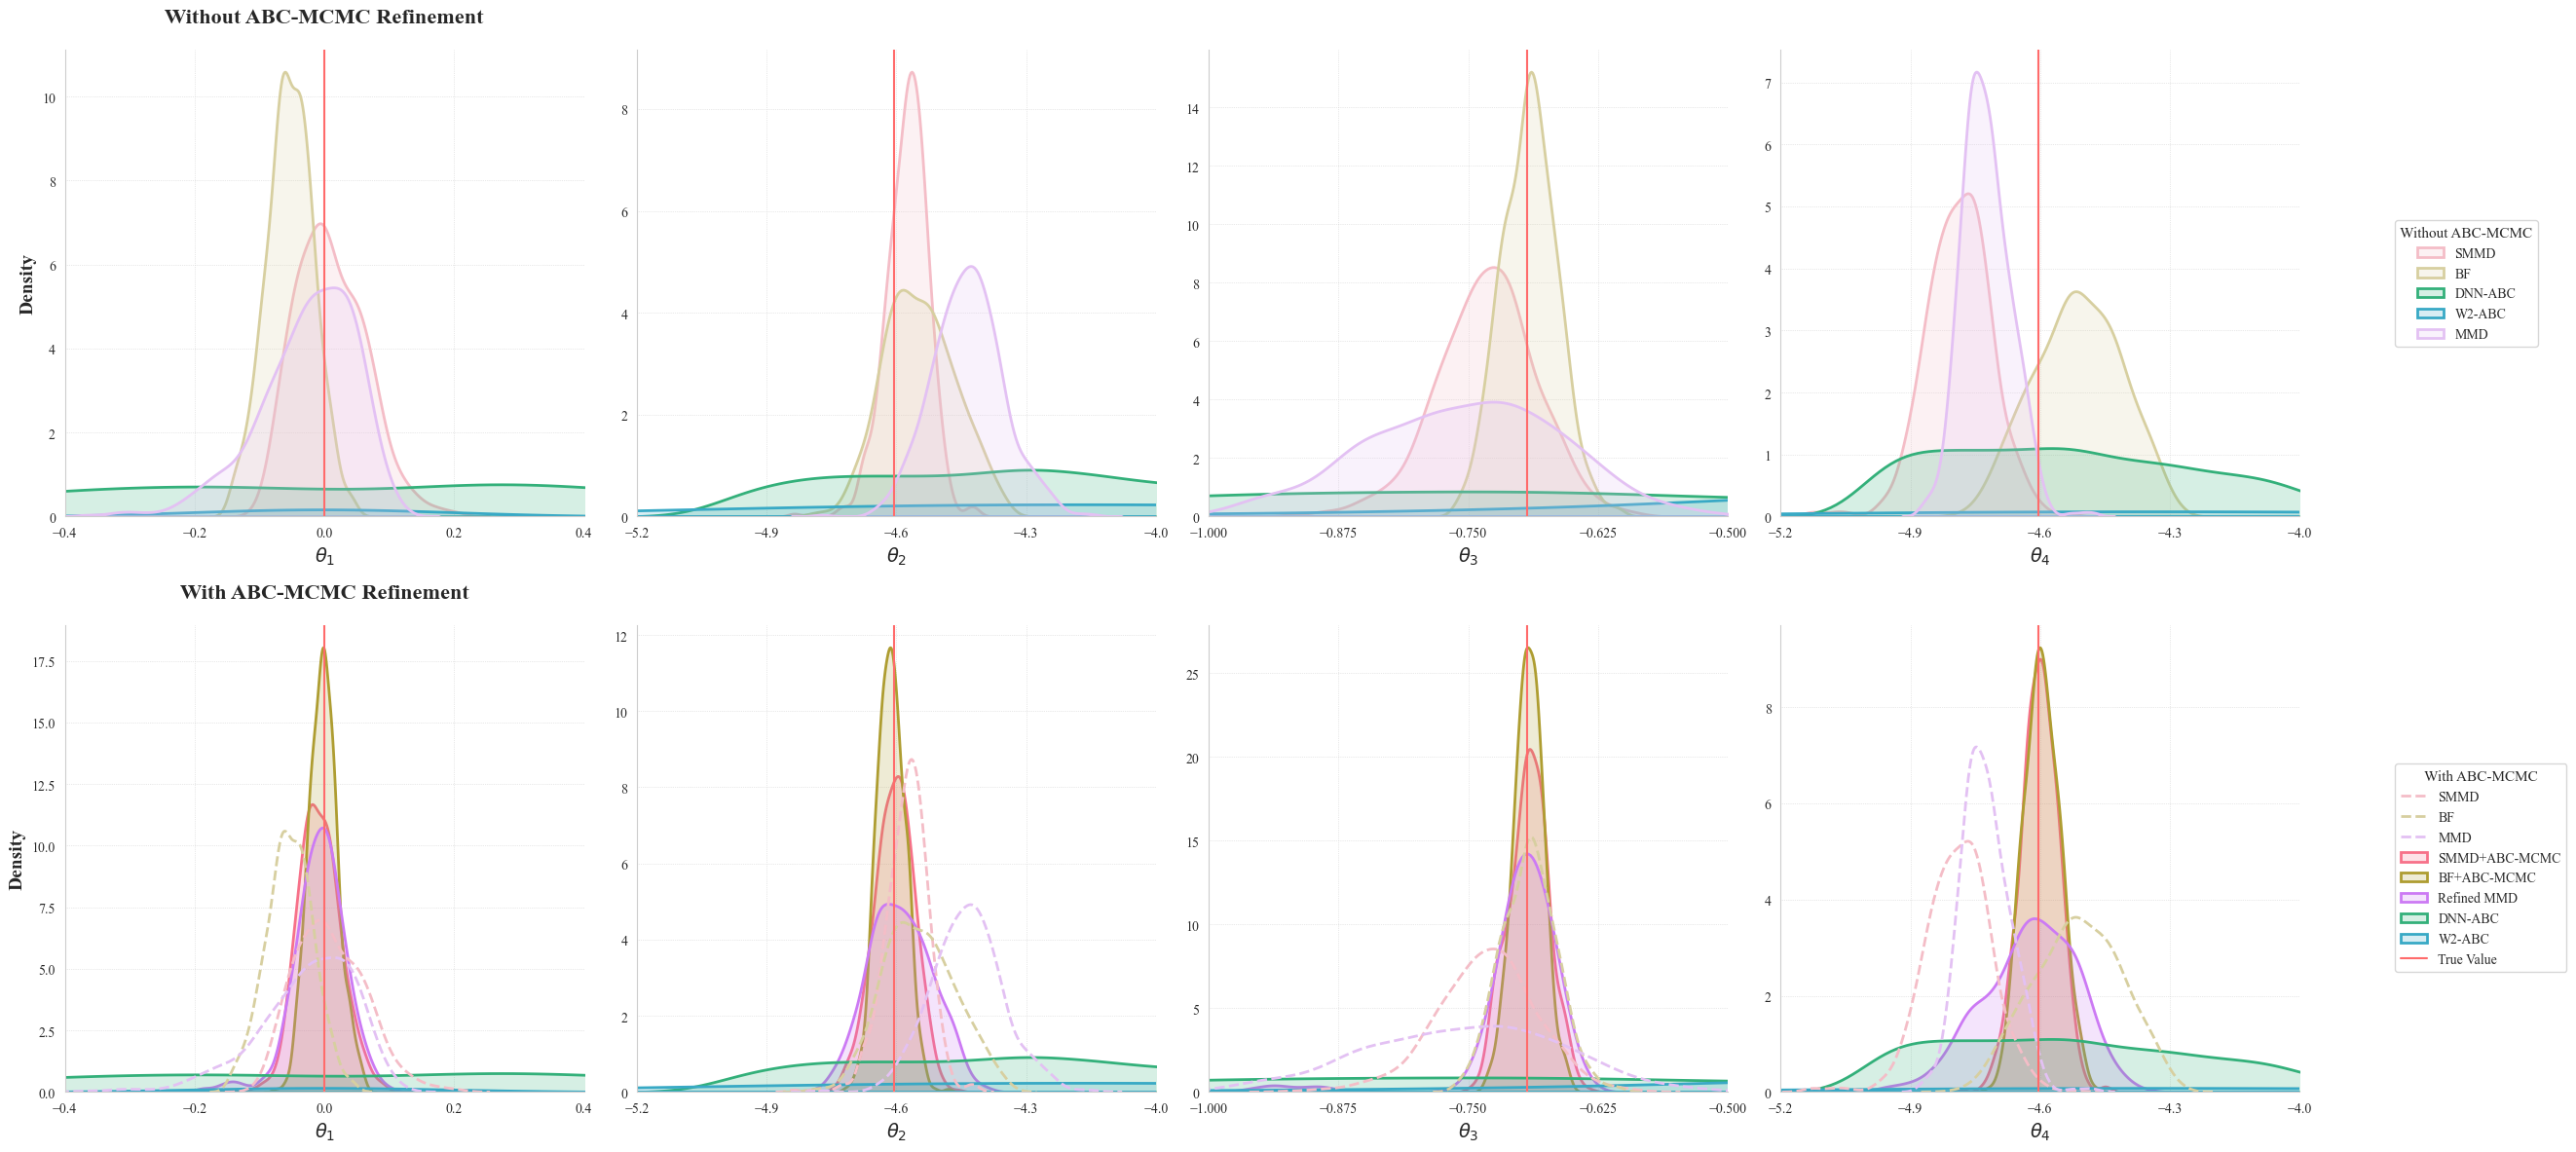

In [34]:
# --------------------------
# 统一全局样式
# --------------------------
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 10,
    'legend.labelspacing': 0.5,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

# --------------------------
# 统一配色方案（保持上下图连贯性）
# --------------------------
base_colors = sns.color_palette("husl", 5)  

# 颜色映射：未优化用浅色/虚线，优化用深色/实线
model_colors = {
    # 基础模型（上下图共用）
    "SMMD": sns.light_palette(base_colors[0])[2],
    "BF": sns.light_palette(base_colors[1])[2],
    "DNN-ABC": base_colors[2],
    "W2-ABC": base_colors[3],
    "MMD": sns.light_palette(base_colors[4])[2],
    # 优化模型（仅下图用）
    "SMMD+ABC-MCMC": base_colors[0],
    "BF+ABC-MCMC": base_colors[1],
    "MMD+ABC-MCMC": base_colors[4],
    "Refined MMD": base_colors[4]  # 与MMD+ABC-MCMC保持一致
}

# --------------------------
# 创建上下拼图布局（2行4列）
# --------------------------
fig, axs = plt.subplots(2, 4, figsize=(30, 12))  # 高度加倍以容纳上下图
plt.subplots_adjust(
    wspace=0.3,  # 列间距
    hspace=0.4,  # 行间距（上下图之间）
    right=0.8    # 右侧留白给图例
)

# 参数范围（上下图保持一致）
x_limits = [
    [-0.4, 0.4],   # theta_0
    [-5.2, -4.0],  # theta_1
    [-1.0, -0.5],  # theta_2
    [-5.2, -4.0],  # theta_3
]

# 初始化所有子图的基础设置
# for i in range(2):  # 2行
#     for j in range(4):  # 4列
#         ax = axs[i, j]
#         ax.set_xlim(x_limits[j])
#         ax.set_xticks(np.linspace(x_limits[j][0], x_limits[j][1], 5))
#         ax.grid(color='lightgray', linestyle=':', linewidth=0.5)
#         sns.despine(ax=ax, top=True, right=True)
#         ax.set_xlabel(f"${upper_labels[j]}$", fontweight='bold')
#         # 仅左侧列显示y轴标签
#         if j == 0:
#             ax.set_ylabel("Density", fontweight='bold')
#         else:
#             ax.set_ylabel("")

# --------------------------
# 上图：未加ABC-MCMC优化
# --------------------------
# 设置上图标题
axs[0, 0].set_title("Without ABC-MCMC Refinement", fontweight='bold', pad=20)

for j in range(4):
    ax = axs[0, j]
    
    # SMMD
    sns.kdeplot(
        nn_ps[:, j],
        ax=ax,
        label="SMMD" if (j == 0) else "",
        color=model_colors["SMMD"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # BF
    sns.kdeplot(
        bf_ps[:, j],
        ax=ax,
        label="BF" if (j == 0) else "",
        color=model_colors["BF"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # DNN-ABC
    sns.kdeplot(
        dnnabc_ps[:, j],
        ax=ax,
        label="DNN-ABC" if (j == 0) else "",
        color=model_colors["DNN-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # W2-ABC
    sns.kdeplot(
        w2abc_ps[:, j],
        ax=ax,
        label="W2-ABC" if (j == 0) else "",
        color=model_colors["W2-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # MMD
    sns.kdeplot(
        mmd_ps[:, j],
        ax=ax,
        label="MMD" if (j == 0) else "",
        color=model_colors["MMD"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # 真实值线
    ax.axvline(true_ps_ls[j], color=truth_color, linestyle="-", linewidth=1.5)

# --------------------------
# 下图：加ABC-MCMC优化
# --------------------------
# 设置下图标题
axs[1, 0].set_title("With ABC-MCMC Refinement", fontweight='bold', pad=20)

for j in range(4):
    ax = axs[1, j]
    
    # 原始模型（虚线，无填充）
    sns.kdeplot(
        nn_ps[:, j],
        ax=ax,
        label="SMMD" if (j == 0) else "",
        color=model_colors["SMMD"],
        linestyle="--",
        linewidth=2,
        fill=False  # 未优化模型无填充
    )
    
    sns.kdeplot(
        bf_ps[:, j],
        ax=ax,
        label="BF" if (j == 0) else "",
        color=model_colors["BF"],
        linestyle="--",
        linewidth=2,
        fill=False
    )
    
    sns.kdeplot(
        mmd_ps[:, j],
        ax=ax,
        label="MMD" if (j == 0) else "",
        color=model_colors["MMD"],
        linestyle="--",
        linewidth=2,
        fill=False
    )
    
    # 优化模型（实线，有填充）
    sns.kdeplot(
        refined_nn_ps[:, j],
        ax=ax,
        label="SMMD+ABC-MCMC" if (j == 0) else "",
        color=model_colors["SMMD+ABC-MCMC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    sns.kdeplot(
        refined_bf_ps[:, j],
        ax=ax,
        label="BF+ABC-MCMC" if (j == 0) else "",
        color=model_colors["BF+ABC-MCMC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    sns.kdeplot(
        refined_mmd_ps[:, j],
        ax=ax,
        label="Refined MMD" if (j == 0) else "",
        color=model_colors["Refined MMD"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # 保持不变的模型（DNN-ABC和W2-ABC）
    sns.kdeplot(
        dnnabc_ps[:, j],
        ax=ax,
        label="DNN-ABC" if (j == 0) else "",
        color=model_colors["DNN-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    sns.kdeplot(
        w2abc_ps[:, j], 
        ax=ax,
        label="W2-ABC" if (j == 0) else "",
        color=model_colors["W2-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2
    )
    
    # 真实值线（与上图保持一致）
    ax.axvline(true_ps_ls[j], color=truth_color, linestyle="-", linewidth=1.5,
               label="True Value" if (j == 0) else "")
    
for i in range(2):  # 2行
    for j in range(4):  # 4列
        ax = axs[i, j]
        ax.set_xlim(x_limits[j])
        ax.set_xticks(np.linspace(x_limits[j][0], x_limits[j][1], 5))
        ax.grid(color='lightgray', linestyle=':', linewidth=0.5)
        sns.despine(ax=ax, top=True, right=True)
        ax.set_xlabel(f"${upper_labels[j]}$", fontweight='bold')
        # 仅左侧列显示y轴标签
        if j == 0:
            ax.set_ylabel("Density", fontweight='bold')
        else:
            ax.set_ylabel("")


# --------------------------
# 分别为上下图创建独立图例
# --------------------------
# 上图图例
handles_upper, labels_upper = axs[0, 0].get_legend_handles_labels()
by_label_upper = dict(zip(labels_upper, handles_upper))
upper_legend = fig.legend(
    by_label_upper.values(), by_label_upper.keys(),
    loc='center left',
    bbox_to_anchor=(0.82, 0.75),  # 上图图例位置
    frameon=True,
    framealpha=0.9,
    edgecolor='lightgray',
    title="Without ABC-MCMC",
    title_fontsize=11,
    borderaxespad=0.5
)

# 下图图例
handles_lower, labels_lower = axs[1, 0].get_legend_handles_labels()
by_label_lower = dict(zip(labels_lower, handles_lower))
lower_legend = fig.legend(
    by_label_lower.values(), by_label_lower.keys(),
    loc='center left',
    bbox_to_anchor=(0.82, 0.25),  # 下图图例位置
    frameon=True,
    framealpha=0.9,
    edgecolor='lightgray',
    title="With ABC-MCMC",
    title_fontsize=11,
    borderaxespad=0.5
)

# 调整布局，确保所有元素可见
plt.tight_layout(rect=[0, 0, 0.8, 1])
# save figure to figures folder
fig.savefig(os.path.join("figures", "lotka_volterra_abc_mcmc_refinement.png"), dpi=300, bbox_inches='tight')
plt.show()

# SIR

In [35]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
d = 2

model_name = ["nn", "bf", "dnnabc","w2abc"]
result_path = os.path.join(os.getcwd(),'SIR', 'result')

truth_color = "#FF6B6B"
est_color = "#4D96FF"
refined_color = "#6BCB77"
upper_labels = ["\\theta_1", "\\theta_2"]

In [37]:
ps_selected_indexs = [6, 0, 0, 0, 5]
nn_ps = np.load(os.path.join(result_path,"nn_ps", f"nn_ps_{ps_selected_indexs[0]}.npy" ))
refined_nn_ps= np.load(os.path.join(result_path,"nn_ps", f"nn_mcmc_{ps_selected_indexs[0]}.npy" ))
bf_ps = np.load(os.path.join(result_path,"bf_ps", f"bf_ps_{ps_selected_indexs[1]}.npy" ))
refined_bf_ps = np.load(os.path.join(result_path,"bf_ps", f"bf_mcmc_{ps_selected_indexs[1]}.npy" ))
dnnabc_ps = np.load(os.path.join(result_path,"dnnabc_ps", f"sir_dnnabc_{ps_selected_indexs[2]}.npy" ))
w2abc_ps = np.load(os.path.join(result_path,"w2abc_ps", f"w2abc_ps_{ps_selected_indexs[3]}.npy" ))
mmd_ps = np.load(os.path.join(os.getcwd(), "sir_mmd", "result", "nn_ps", f"nn_ps_{ps_selected_indexs[4]}.npy"))
refined_mmd_ps = np.load(os.path.join(os.getcwd(), "sir_mmd", "result", "nn_ps", f"nn_mcmc_{ps_selected_indexs[4]}.npy"))

print(f"nn_ps shape: {nn_ps.shape}")
print(f"refined_nn_ps shape: {refined_nn_ps.shape}")
print(f"bf_ps shape: {bf_ps.shape}")
print(f"refined_bf_ps shape: {refined_bf_ps.shape}")
print(f"dnnabc_ps shape: {dnnabc_ps.shape}")
print(f"w2abc_ps shape: {w2abc_ps.shape}")
print(f"mmd_ps shape: {mmd_ps.shape}")
print(f"refined_mmd_ps shape: {refined_mmd_ps.shape}")

nn_ps shape: (500, 2)
refined_nn_ps shape: (500, 2)
bf_ps shape: (500, 2)
refined_bf_ps shape: (500, 2)
dnnabc_ps shape: (599, 2)
w2abc_ps shape: (612, 2)
mmd_ps shape: (500, 2)
refined_mmd_ps shape: (500, 2)


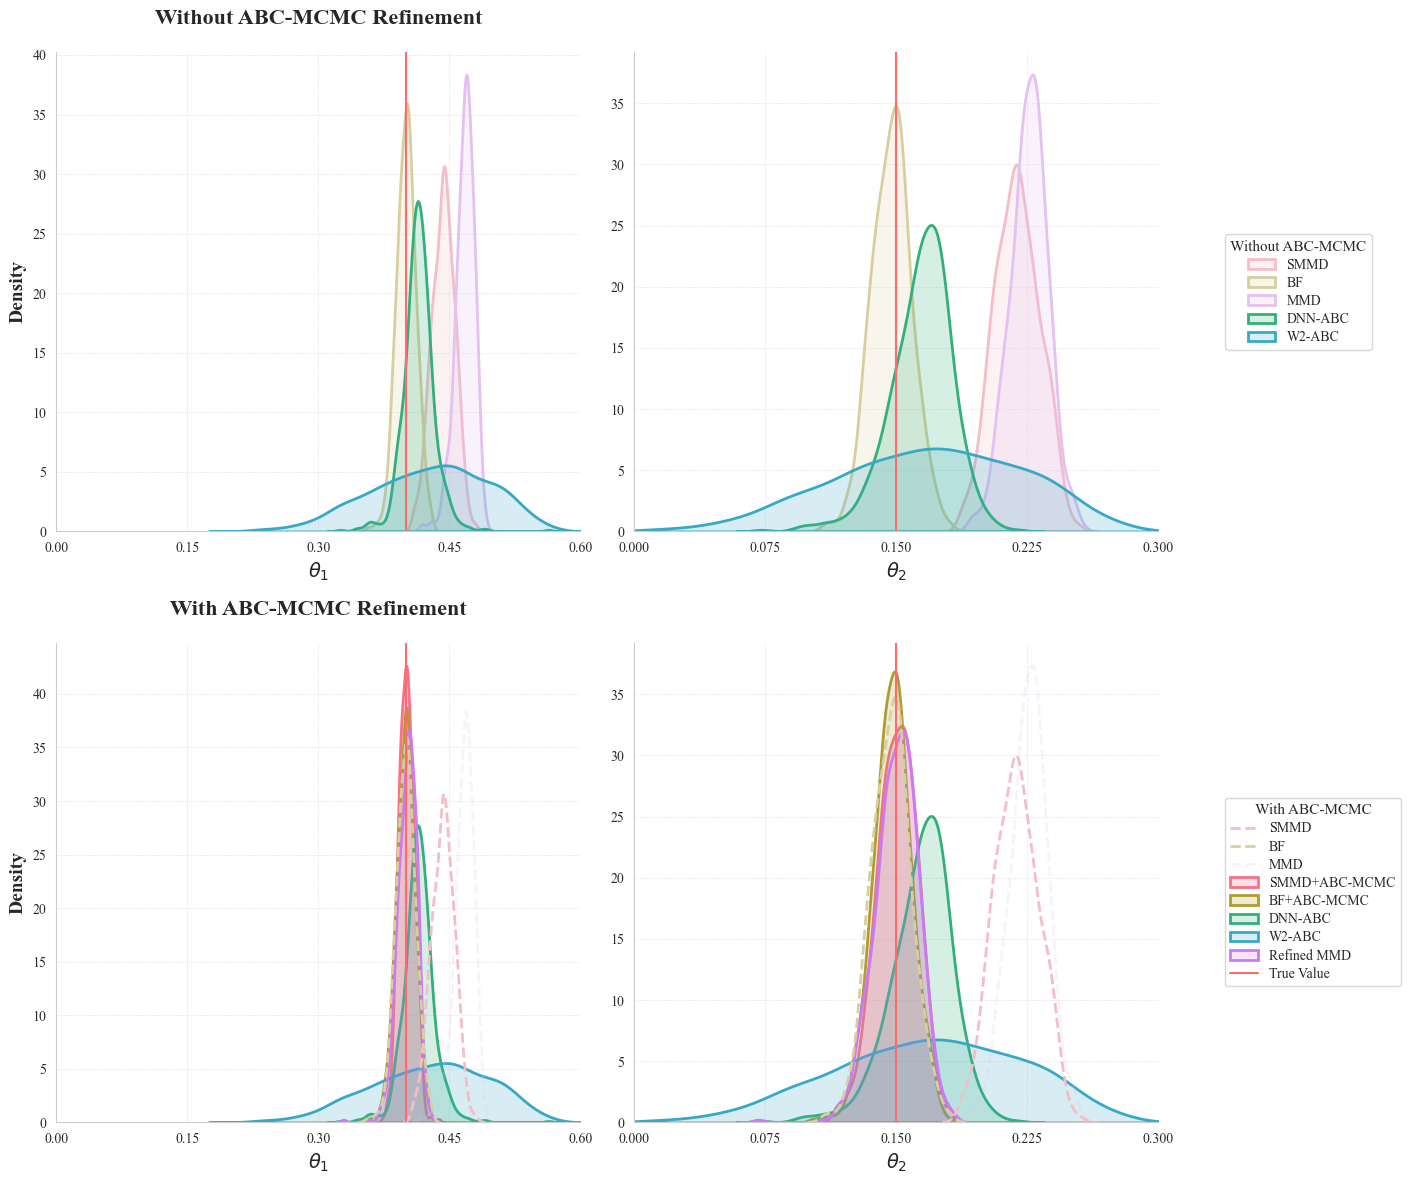

In [38]:
# --------------------------
# 统一全局样式
# --------------------------
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 10,
    'legend.labelspacing': 0.3,  # 减小图例项间距
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

# --------------------------
# 改进的配色方案
# --------------------------
base_colors = sns.color_palette("husl", 5)  # 5个基础颜色   

# 为每种方法分配独特的颜色和线型组合
model_colors = {
    # 基础模型（上下图共用）
    "SMMD": sns.light_palette(base_colors[0])[2],
    "BF": sns.light_palette(base_colors[1])[2],
    "DNN-ABC": base_colors[2],
    "W2-ABC": base_colors[3],
    "MMD": sns.light_palette(base_colors[4])[2],
    # 优化模型（仅下图用）
    "SMMD+ABC-MCMC": base_colors[0],
    "BF+ABC-MCMC": base_colors[1],
    "MMD+ABC-MCMC": base_colors[4],
    "Refined MMD": base_colors[4]  # 与MMD+ABC-MCMC保持一致
}

# --------------------------
# 创建上下子图布局（2行2列）
# --------------------------
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
# 调整布局，为右侧图例留出空间并增加行间距
plt.subplots_adjust(
    wspace=0.3, 
    hspace=0.5,  # 增加行间距
    right=0.78,
    top=0.92,    # 顶部边距
    bottom=0.08
)

true_ps = [0.4, 0.15]
x_limits = {
    0: (0, 0.6),
    1: (0, 0.3),
}



# 设置所有子图的基础属性
# for i in range(2):  # 两行
#     for j in range(2):  # 两列
#         ax = axs[i, j]
#         ax.set_xlim(x_limits[j])
#         ax.set_xticks(np.linspace(x_limits[j][0], x_limits[j][1], 5))
#         ax.grid(color='lightgray', linestyle=':', linewidth=0.5)
#         sns.despine(ax=ax, top=True, right=True)
#         ax.set_xlabel(f"${upper_labels[j]}$", fontweight='bold')
#         # 仅第一列显示y轴标签
#         if j == 0:
#             ax.set_ylabel("Density", fontweight='bold')
#         else:
#             ax.set_ylabel("")
#         # 绘制真实后验分布

# --------------------------
# 上图：未加ABC-MCMC优化的结果
# --------------------------
# 添加居中标题
# fig.text(0.5, 0.94, "Without ABC-MCMC Refinement", 
#          ha='center', va='center', fontweight='bold', fontsize=16)
axs[0, 0].set_title("Without ABC-MCMC Refinement", fontweight='bold', pad=20)

for j in range(d):
    ax = axs[0, j]  # 第一行

    sns.kdeplot(
        nn_ps[:, j],
        ax=ax,
        label="SMMD" if j == 0 else "",
        linewidth=2,
        color=model_colors["SMMD"],
        linestyle="-",
        fill=True,
        alpha=0.2
    )
    sns.kdeplot(
        bf_ps[:, j],
        ax=ax,
        label="BF" if j == 0 else "",
        linewidth=2,
        color=model_colors["BF"],
        linestyle="-",
        fill=True,
        alpha=0.2
    )
    sns.kdeplot(
        mmd_ps[:, j],
        ax=ax,
        label="MMD" if j == 0 else "",
        linewidth=2,
        color=model_colors["MMD"],
        linestyle="-",
        fill=True,
        alpha=0.2
    )
    sns.kdeplot(
        dnnabc_ps[:, j],
        ax=ax,
        label="DNN-ABC" if j == 0 else "",
        linewidth=2,
        color=model_colors["DNN-ABC"],
        linestyle="-",
        fill=True,
        alpha=0.2
    )
    sns.kdeplot(
        w2abc_ps[:, j],
        ax=ax,
        label="W2-ABC" if j == 0 else "",
        linewidth=2,
        color=model_colors["W2-ABC"],
        linestyle="-",
        fill=True,
        alpha=0.2
    )

# --------------------------
# 下图：添加ABC-MCMC优化的结果
# --------------------------
# 添加居中标题
# fig.text(0.5, 0.48, "With ABC-MCMC Refinement", 
#          ha='center', va='center', fontweight='bold', fontsize=16)
axs[1, 0].set_title("With ABC-MCMC Refinement", fontweight='bold', pad=20)

for j in range(d):
    ax = axs[1, j]  # 第二行
    
    # 绘制包含优化的方法
    sns.kdeplot(
        nn_ps[:, j],
        ax=ax,
        label="SMMD" if j == 0 else "",
        color=model_colors["SMMD"],
        linestyle="--",
        linewidth=2,
    )
    sns.kdeplot(
        bf_ps[:, j],
        ax=ax,
        label="BF" if j == 0 else "",
        color=model_colors["BF"],
        linestyle="--",
        linewidth=2,
    )
    sns.kdeplot(
        mmd_ps[:, j],
        ax=ax,
        label="MMD" if j == 0 else "",
        color=model_colors["MMD"],
        linestyle="--",
        linewidth=2,
        alpha=0.2,  # 添加轻微透明度以增强视觉效果
    )
    sns.kdeplot(
        refined_nn_ps[:, j],
        ax=ax,
        label="SMMD+ABC-MCMC" if j == 0 else "",
        color=model_colors["SMMD+ABC-MCMC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2,  # 添加轻微透明度以增强视觉效果
    )
    sns.kdeplot(
        refined_bf_ps[:, j],
        ax=ax,
        label="BF+ABC-MCMC" if j == 0 else "",
        color=model_colors["BF+ABC-MCMC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2,  # 添加轻微透明度以增强视觉效果
    )
    sns.kdeplot(
        dnnabc_ps[:, j],
        ax=ax,
        label="DNN-ABC" if j == 0 else "",
        color=model_colors["DNN-ABC"],
        linestyle="-",
        linewidth=2,
        fill=True,
        alpha=0.2,  # 添加轻微透明度以增强视觉效果
    )
    sns.kdeplot(
        w2abc_ps[:, j],
        ax=ax,
        label="W2-ABC" if j == 0 else "",
        color=model_colors["W2-ABC"],
        linestyle="-",
        fill=True,
        alpha=0.2,  # 添加轻微透明度以增强视觉效果
        linewidth=2,
    )
    sns.kdeplot(
        refined_mmd_ps[:, j],
        ax=ax,
        label="Refined MMD" if j == 0 else "",
        color=model_colors["Refined MMD"],
        linestyle="-",
        fill=True,
        alpha=0.2,  # 添加轻微透明度以增强视觉效果
        linewidth=2,
    )


for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        ax.axvline(
            x=true_ps[j], 
            color=truth_color,
            linestyle="-",
            linewidth=1.5,
            label="True Value" if (i == 1 and j == 0) else "",  # 只在右下角子图添加一次标签

        )

for i in range(2):  # 两行
    for j in range(2):  # 两列
        ax = axs[i, j]
        ax.set_xlim(x_limits[j])
        ax.set_xticks(np.linspace(x_limits[j][0], x_limits[j][1], 5))
        ax.grid(color='lightgray', linestyle=':', linewidth=0.5)
        sns.despine(ax=ax, top=True, right=True)
        ax.set_xlabel(f"${upper_labels[j]}$", fontweight='bold')
        # 仅第一列显示y轴标签
        if j == 0:
            ax.set_ylabel("Density", fontweight='bold')
        else:
            ax.set_ylabel("")
        # 绘制真实后验分布
# --------------------------
# 分别为上下图创建独立图例
# --------------------------
# 上图图例
handles_upper, labels_upper = axs[0, 0].get_legend_handles_labels()
by_label_upper = dict(zip(labels_upper, handles_upper))
upper_legend = fig.legend(
    by_label_upper.values(), by_label_upper.keys(),
    loc='center left', 
    bbox_to_anchor=(0.82, 0.75),  # 上图图例位置
    frameon=True, 
    framealpha=0.9, 
    edgecolor='lightgray',
    title="Without ABC-MCMC", 
    title_fontsize=11,
    borderaxespad=0.2
)

# 下图图例
handles_lower, labels_lower = axs[1, 0].get_legend_handles_labels()
by_label_lower = dict(zip(labels_lower, handles_lower))
lower_legend = fig.legend(
    by_label_lower.values(), by_label_lower.keys(),
    loc='center left', 
    bbox_to_anchor=(0.82, 0.25),  # 下图图例位置
    frameon=True, 
    framealpha=0.9, 
    edgecolor='lightgray',
    title="With ABC-MCMC", 
    title_fontsize=11,
    borderaxespad=0.2
)

# 调整布局，确保所有元素可见
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.savefig(os.path.join("figures", "sir_abc_mcmc_refinement.png"), dpi=300, bbox_inches='tight')
plt.show()
    